In [1]:
import os
from glob import glob
import copy 

In [2]:
#from dask import delayed
#from dask import compute
#from dask.distributed import Client, progress
#client = Client(threads_per_worker=4, n_workers=20)

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from root_pandas import read_root 
from ROOT import TFile

Welcome to JupyROOT 6.16/00


/home/jcordero/CMS/SMP_ZGamma/envSMP/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [4]:
'''
from guppy import hpy
h = hpy()
print(h.heap())
''';

In [5]:
from Common.CommonHelper  import CommonHelper
from Config.ConfigManager import ConfigManager
from Samples.DataSample   import DataSample
from Samples.DataFile     import DataFile
from Samples.Event        import Event
from Samples.DataFile     import DataFile
from Samples.DataEras     import DataEras
from Samples.ConfigData   import ConfigData
from Cuts.Cuts            import Cuts
from Plotter.Histo        import Histo
from Plotter.HistoVar     import HistoVar
from Plotter.HistoSample  import HistoSample
from Plotter.HistoEras    import HistoEras

In [6]:
def getSamplesPath(path):
    return glob(os.path.join(path,"*[!.][!s][!h]"))

def getSampleFromPath(path):
    return path.split("/")[-1]

def getFileFromPath(path):
    return path.split("/")[-1]

def getFiles(path,sample):
    return glob(os.path.join(path,sample,"output*[!v_0]*"))

In [7]:
def isPathEmpty(path,samp):
    file = glob(os.path.join(path, getSampleFromPath(samp),"output*"))
    if file:
        return False
    else:
        return True

In [8]:
def FillData(path,HStack):

    for histo in HStack:
        filename = os.path.join(path,histo.name)+'.csv'
        df = pd.read_csv(filename)
        histo.fill(df)
    
    return HStack

def FillLoop(selection, Sample, HStack, Cut,Short=False):    
    for n,file in enumerate(Sample):
        if n > 0 and Short: break;
        for i,iEvent in enumerate(file):
            event = Event(iEvent)
            if selection != "ee":
                event = Event(event[Cut.Pass(event,Region=None)])
                if file.name == 'DYJets' and Cut.VetoDY is not None:
                    event = Event(event[Cut._vetoDY(event)])
            
            for histo in HStack:
                if "EE" in histo.name:
                    eventEE = Event(event[Cut.EE(event)])
                    histo.fill( eventEE.value(histo.name[:-3]),
                                eventEE.value('genWeight')*eventEE.value('eventWeight')*Sample.getSF())
                elif "EB" in histo.name:
                    eventEB = Event(event[Cut.EB(event)])
                    histo.fill( eventEB.value(histo.name[:-3]),
                                eventEB.value('genWeight')*eventEB.value('eventWeight')*Sample.getSF())
                else:                    
                    histo.fill( event.value(histo.name),
                                event.value('genWeight')*event.value('eventWeight')*Sample.getSF())
    return HStack

In [9]:
Manager = ConfigManager()
datapath     = "/home/jcordero/CMS/data/"
histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
figpath      = "/home/jcordero/CMS/SMP_ZGamma/fig/"
Manager.CreateProject(histsavepath)
Manager.CreateProject(figpath)


PhotonRadiation = None
OppositeCharge = True
#VetoDY = True
VetoDY = False #right veto settings
#VetoDY = None

Cut = Cuts(PhotonRadiation = PhotonRadiation, OppositeCharge = OppositeCharge, VetoDY = VetoDY)

#selection = "mumug"
#selection = "elelg
selection = "ee"

#chuncksize = 5000
chuncksize = 10000
#chuncksize = 1000

#Short = True
Short = False

fromRoot = True
#fromRoot = False

#merge = False
merge = True

#eras = ['2016','2017','2018']
#eras = ['2017','2018']
#eras = ['2016']
#eras = ['2017']
eras = ['2018']

DEra = DataEras(name = "AllEras")
HEra = HistoEras(name = "AllEras")
HUnmergeEra = HistoEras()
for era in eras:
    histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
    figpath      = "/home/jcordero/CMS/SMP_ZGamma/fig/"
    dirstructure = os.path.join(era,selection,Manager.Date())
    
    print('Loading era {} for selection {}'.format(era,selection))
    path = datapath+"data_{}/{}/SMP_ZG/Files/{}/{}/".format(era,Manager.legacy(era),selection,Manager.latestDir(era,selection))
    histsavepath = os.path.join(histsavepath,dirstructure)
    figpath = os.path.join(figpath,dirstructure)
    Manager.CreateFigStructure(figpath)
    

    if fromRoot:
        print('---Building data files')
        DSample = DataSample()
        for samp in getSamplesPath(path):
            if not isPathEmpty(path,samp):# and getSampleFromPath(samp) == "DYJets":
                print(getSampleFromPath(samp))
                DSample.append( DataFile(path, getSampleFromPath(samp), era, chuncksize) )
        DEra.append(DSample,name = era)

        Samples = DSample.getSamples()
    else:
        Samples = [getSampleFromPath(samp) for samp in getSamplesPath(histsavepath)]
    #Samples = ['ZGToLLG','DYJets']
    #Samples = ['ZGToLLG']
    #Samples = ['TTTo2L2Nu','WJets']

    print('---Filling in histograms')
    HSample = HistoSample()
    for sample in Samples:
        print(sample)
        HVar = HistoVar()
        if fromRoot:
            HSample.append(FillLoop(selection, DSample[sample], HVar.initialize(BinType=selection, binfile="bins.csv" if selection != "ee" else "bins_ee.csv"), Cut, Short), sample)
        else:
            HSample.append(FillData(os.path.join(histsavepath,sample),
                                    HVar.initialize(Type="Normal",BinType=selection),
                                   ),
                          sample)            
    
    HUnmergeSmaple = copy.deepcopy(HSample)
    if fromRoot and merge:
        if selection == "mumug":
            HSample.merge(ConfigData().DoubleMuon(era),name ="DoubleMuon")
            HSample.merge(ConfigData().Diboson(era),name ="Diboson")
        elif selection == "elelg":
            HSample.merge(ConfigData().DoubleEG(era),name ="DoubleEG")
            HSample.merge(ConfigData().Diboson(era),name ="Diboson")
        elif selection == "ee":
            HSample.merge(ConfigData().Electron(era),name ="Electron")
            HSample.merge(ConfigData().Diboson(era),name ="Diboson")

    
    HEra.append(HSample, name = era)
    HUnmergeEra.append(HUnmergeSmaple, name = era)

dirstructure = os.path.join(HEra.name,selection,Manager.Date())
path = datapath+"data_{}/{}/SMP_ZG/Files/{}/{}/".format(HEra.name,Manager.legacy(era),selection,Manager.latestDir(era,selection))
figpath      = "/home/jcordero/CMS/SMP_ZGamma/fig/"
figpath = os.path.join(figpath,dirstructure)
Manager.CreateFigStructure(figpath)

Loading era 2018 for selection ee
---Building data files
WWTo2L2Nu
DYJets
Electron_2018A
Electron_2018B
ZZTo4L
ZZTo2L2Nu
Electron_2018C
TTTo2L2Nu
WZTo3LNu
WJets
ZZTo2L2Q
Electron_2018D
---Filling in histograms
WWTo2L2Nu
DYJets
Electron_2018A
Electron_2018B
ZZTo4L
ZZTo2L2Nu
Electron_2018C
TTTo2L2Nu
WZTo3LNu
WJets
ZZTo2L2Q
Electron_2018D


In [10]:
print(HEra.name,HEra.names,HEra['2018'].names)
print(HEra['2018']['DYJets']['dileptonM'].values)
print()
print(DEra.name,DEra.names,DEra['2018'].names)
print(DEra['2018']['DYJets'][0])

#print(HEra['2018']['DYJets']['dileptonM'].values)
#dir(DEra[0]['DYJets'][0])
print()
print(DEra['2018']['DYJets'][0].N())
print(dir(DEra['2018']['DYJets'][0]))

AllEras ['2018'] ['DYJets', 'TTTo2L2Nu', 'WJets', 'Electron', 'Diboson']
[71394.09285402298, 83011.00432443619, 97884.7070145607, 114448.63673782349, 135443.47672462463, 159283.80799913406, 191662.3726568222, 239953.28793907166, 308466.36148393154, 420750.84465408325, 613946.2817821503, 1008526.4197044373, 1814306.5149726868, 3386798.7854156494, 5456405.315673828, 6266530.428588867, 2862279.9561157227, 1213023.3258018494, 563379.7252597809, 309655.28894901276, 196238.03225183487, 192553.96591234207, 198001.3656873703, 125245.67814254761, 87680.01627349854]

AllEras ['2018'] ['WWTo2L2Nu', 'DYJets', 'Electron_2018A', 'Electron_2018B', 'ZZTo4L', 'ZZTo2L2Nu', 'Electron_2018C', 'TTTo2L2Nu', 'WZTo3LNu', 'WJets', 'ZZTo2L2Q', 'Electron_2018D']
DataFile(path=/home/jcordero/CMS/data/data_2018/rereco/SMP_ZG/Files/ee/EfficiencyCorrection/files_zee/V3/DYJets/output_DYJets_30.root,
         name=DYJets)

1197050
['Diboson', 'DoubleEG', 'DoubleMuon', 'Electron', 'N', 'Runs', 'Total', '__class__', '__

In [11]:
"Yes" if True else "No"

'Yes'

In [12]:
histsavepath = '/home/jcordero/CMS/SMP_ZGamma/histo/2018/ee/20200710'
if fromRoot:
    HEra['2018'].savehists(histsavepath)

HistoVar /home/jcordero/CMS/SMP_ZGamma/histo/2018/ee/20200710/DYJets
HistoVar /home/jcordero/CMS/SMP_ZGamma/histo/2018/ee/20200710/TTTo2L2Nu
HistoVar /home/jcordero/CMS/SMP_ZGamma/histo/2018/ee/20200710/WJets
HistoVar /home/jcordero/CMS/SMP_ZGamma/histo/2018/ee/20200710/Electron
HistoVar /home/jcordero/CMS/SMP_ZGamma/histo/2018/ee/20200710/Diboson


In [13]:
#HSample.merge(["WZTo2L2Q","WZTo3LNu","ZZTo2L2Nu","ZZTo2L2Q","ZZTo4L"],name ="Diboson")
#HSample.merge(['WWTo2L2Nu',"Diboson",],name ="Diboson")
#HEra['2018'].names

/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoSample.py:203: RuntimeWarning: invalid value encountered in true_divide
  Ratio = Data/MC
/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoSample.py:205: RuntimeWarning: invalid value encountered in true_divide
  err = Data/MC*(np.sqrt(1/Data + 1/MC))
/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoSample.py:205: RuntimeWarning: divide by zero encountered in true_divide
  err = Data/MC*(np.sqrt(1/Data + 1/MC))
/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoEras.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  FIG = plt.figure(figsize=(11*len(Runs),10))
/home/jcordero/CMS/SMP_ZGamma/python/Plotter/HistoSample.py:342: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_ysca

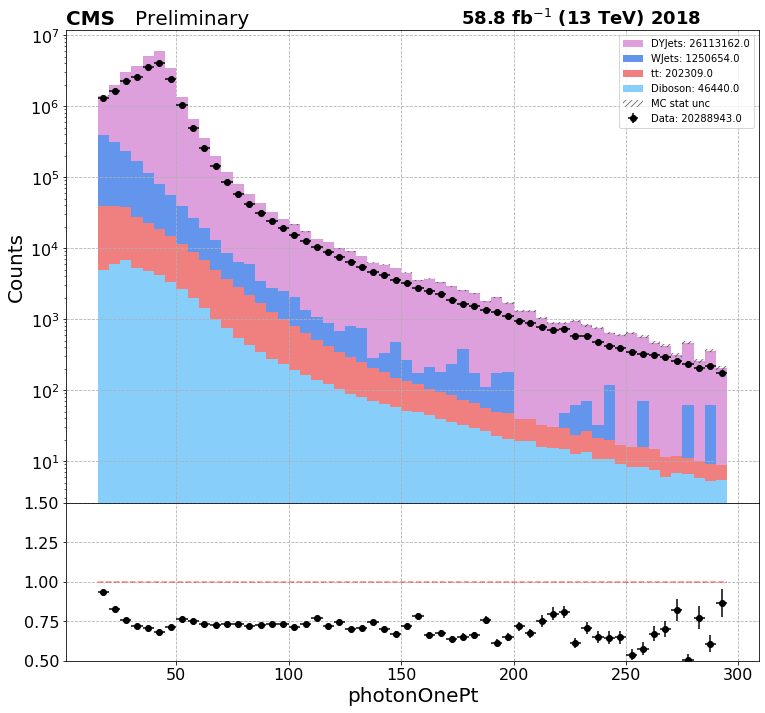

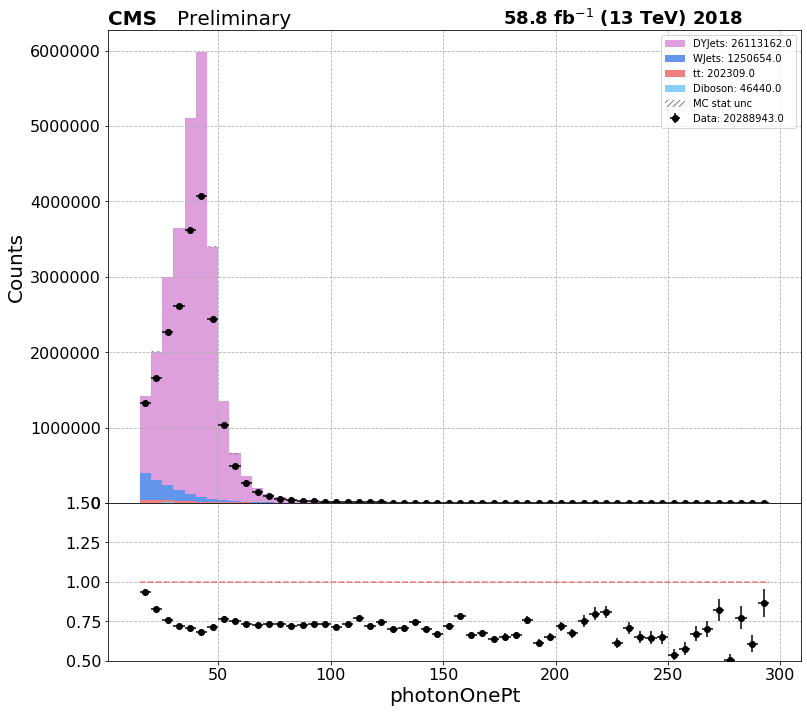

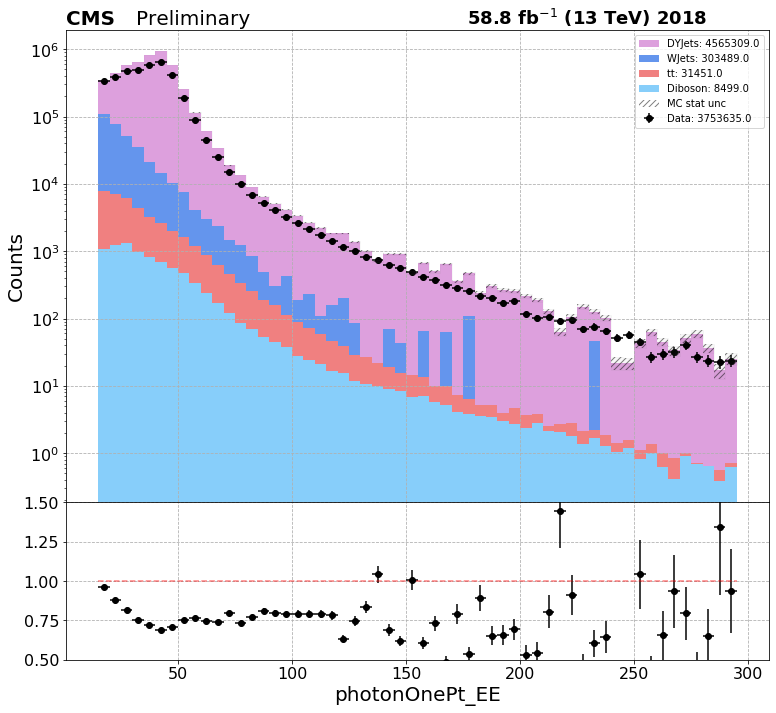

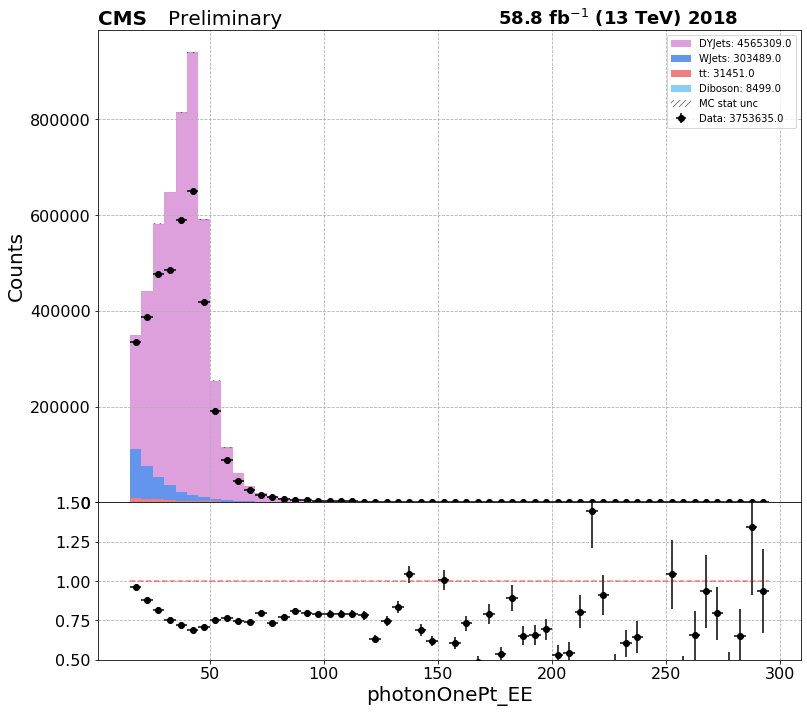

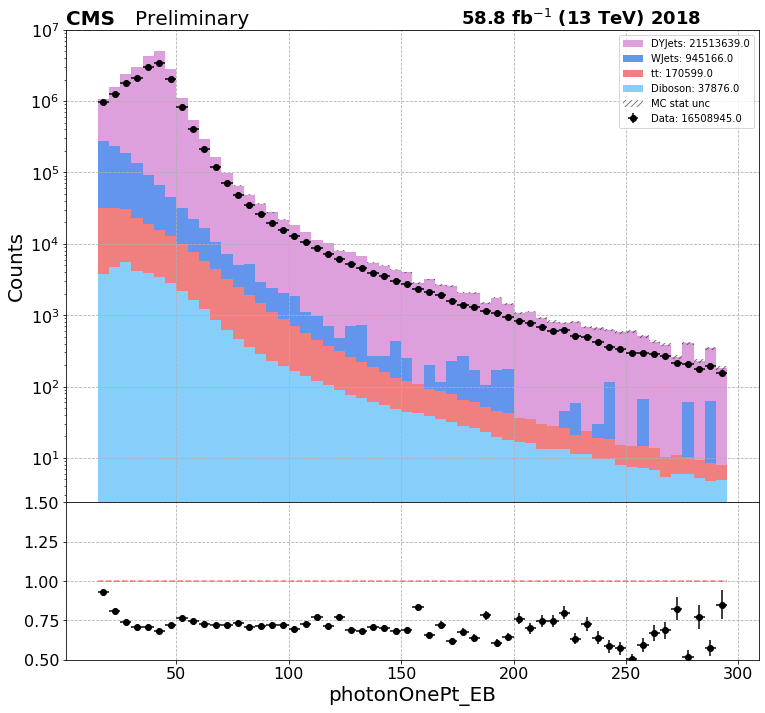

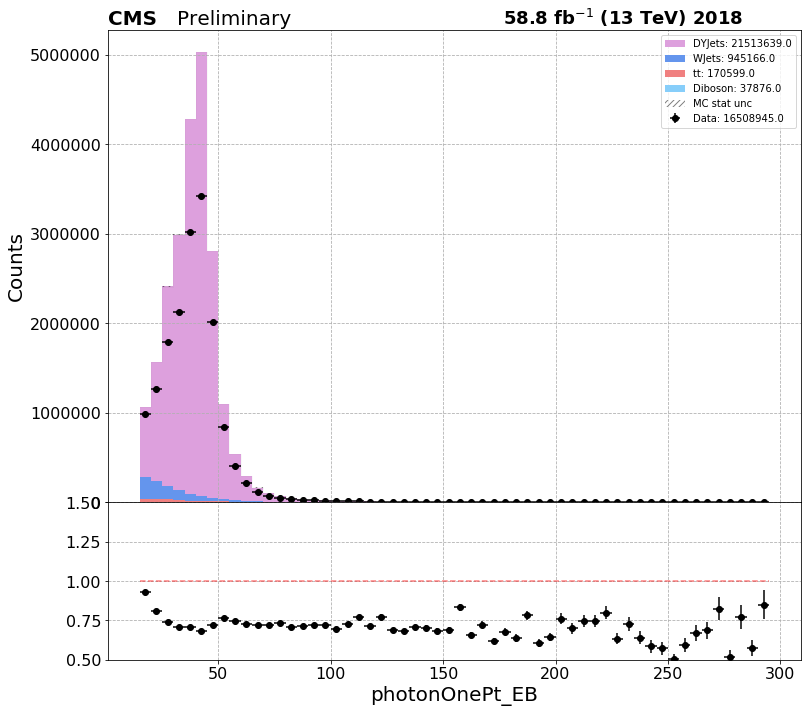

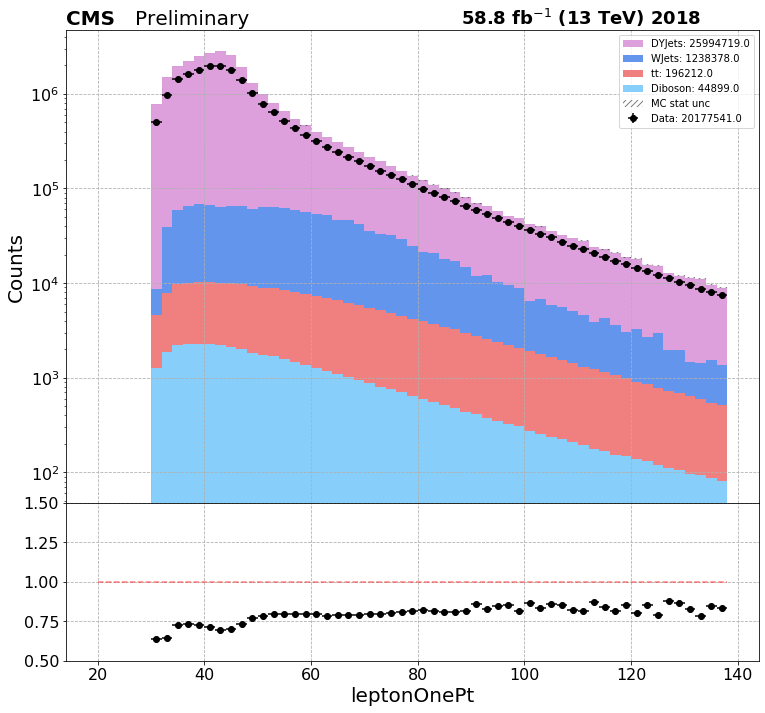

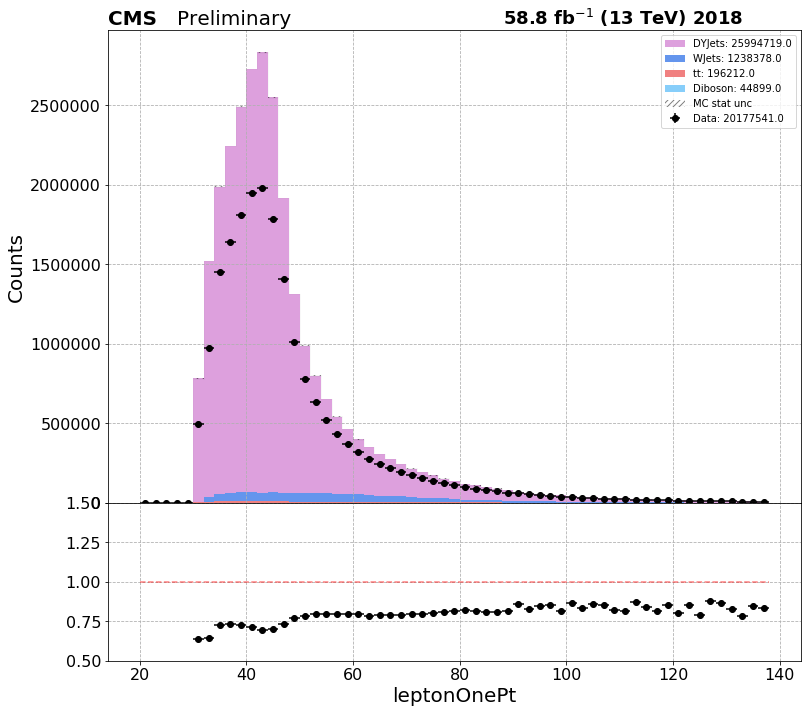

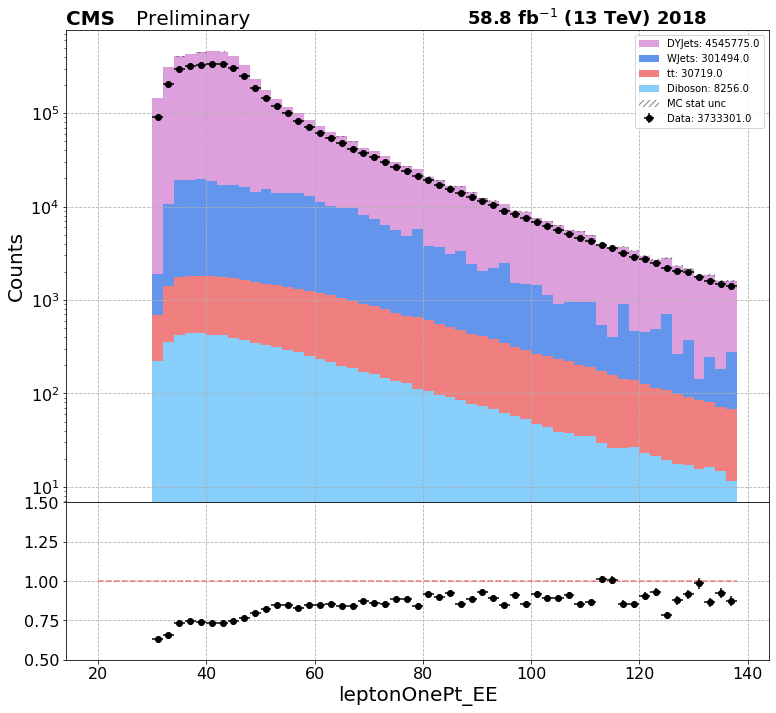

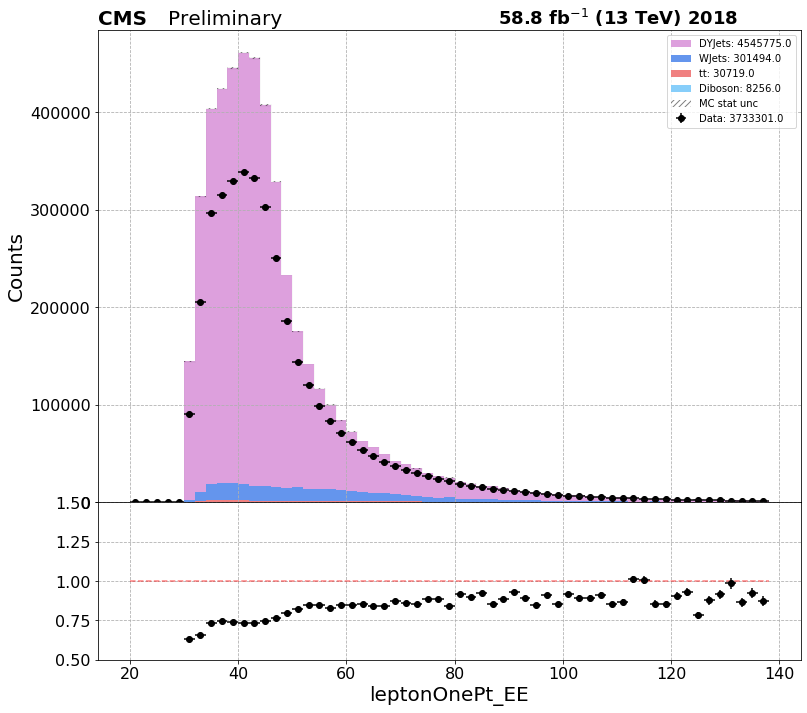

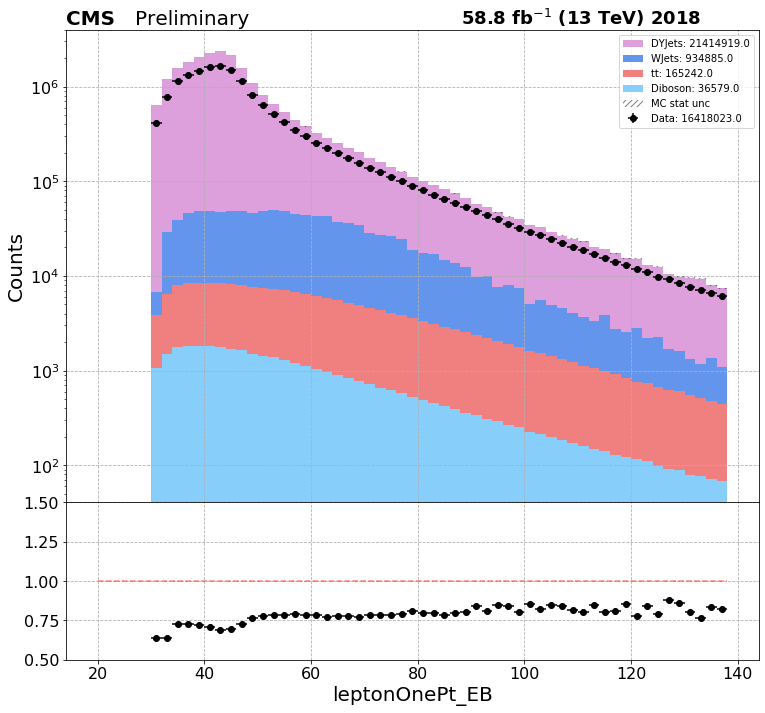

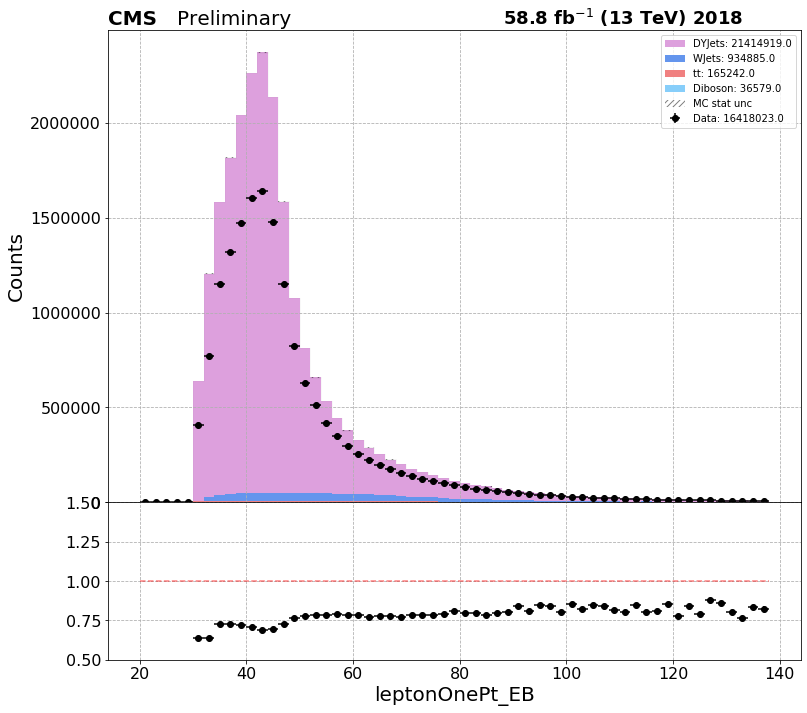

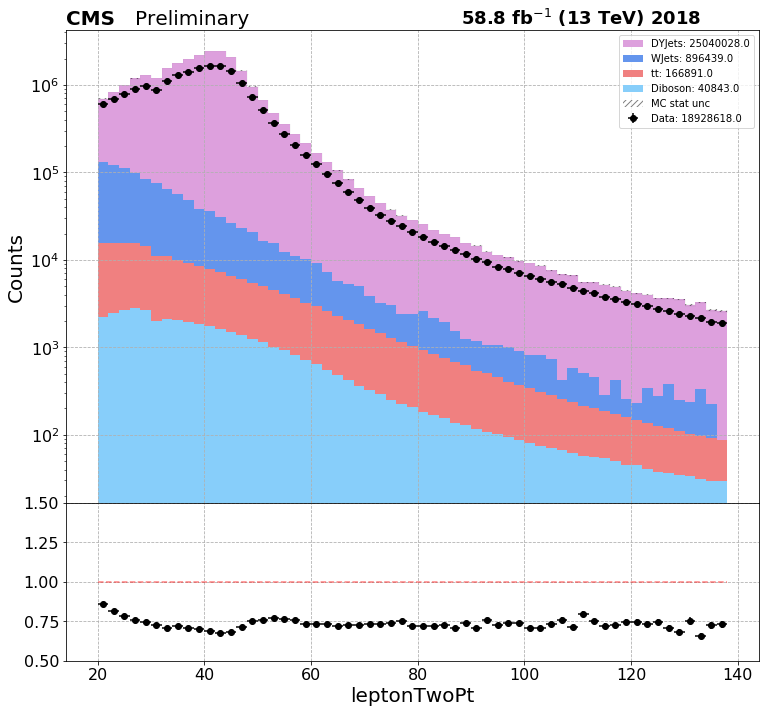

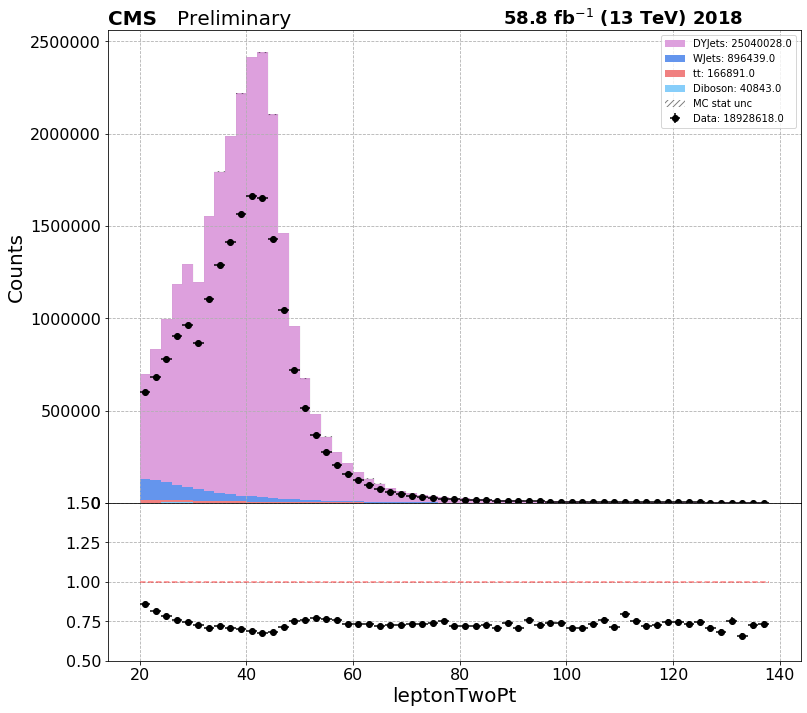

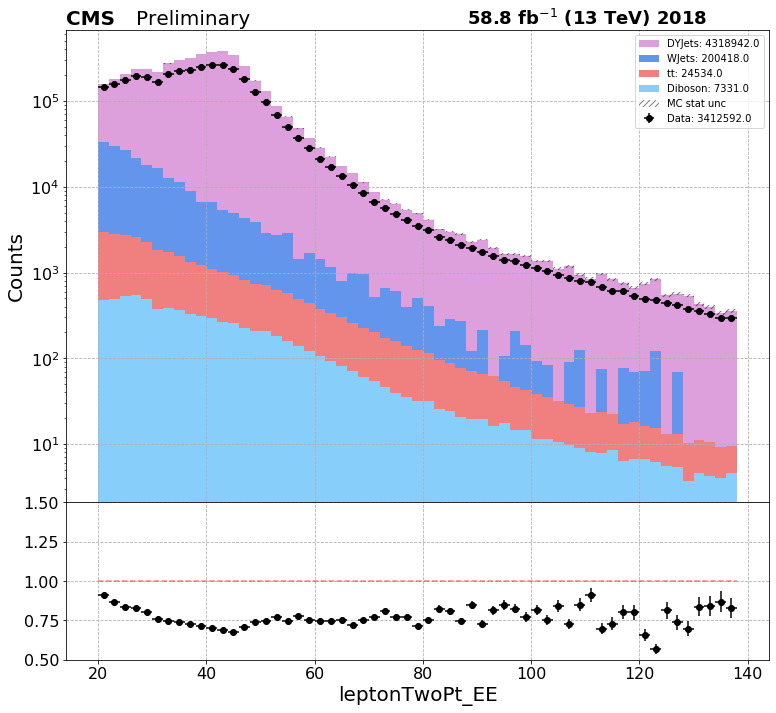

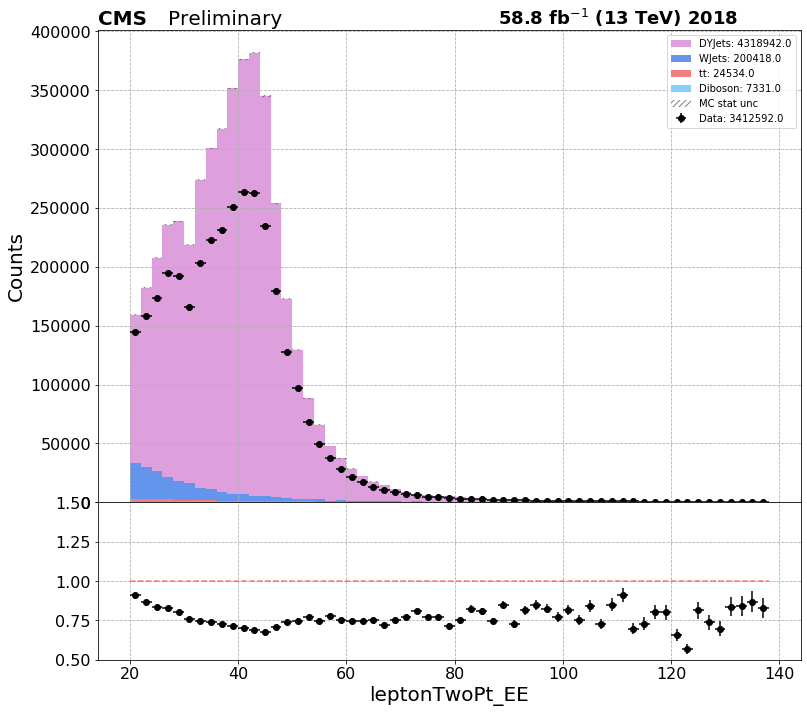

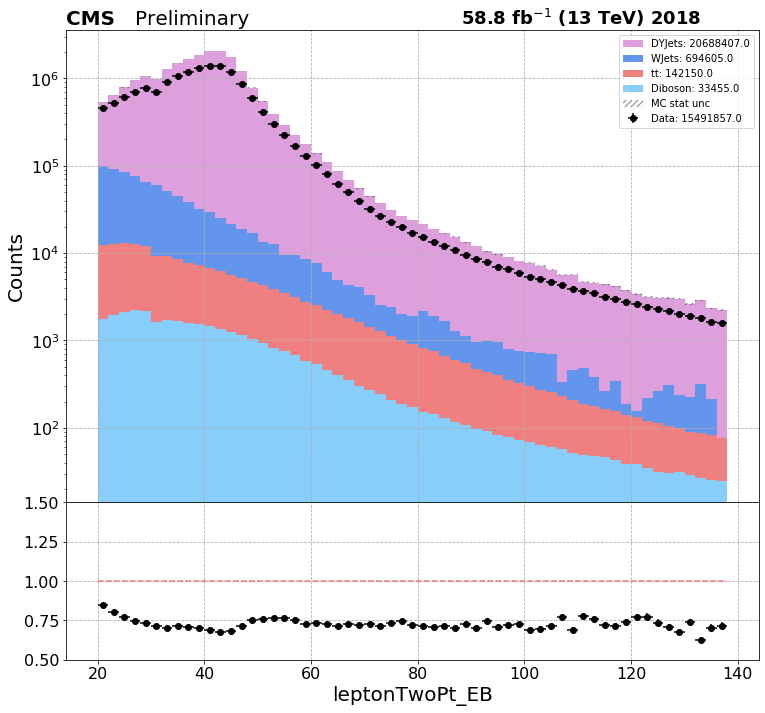

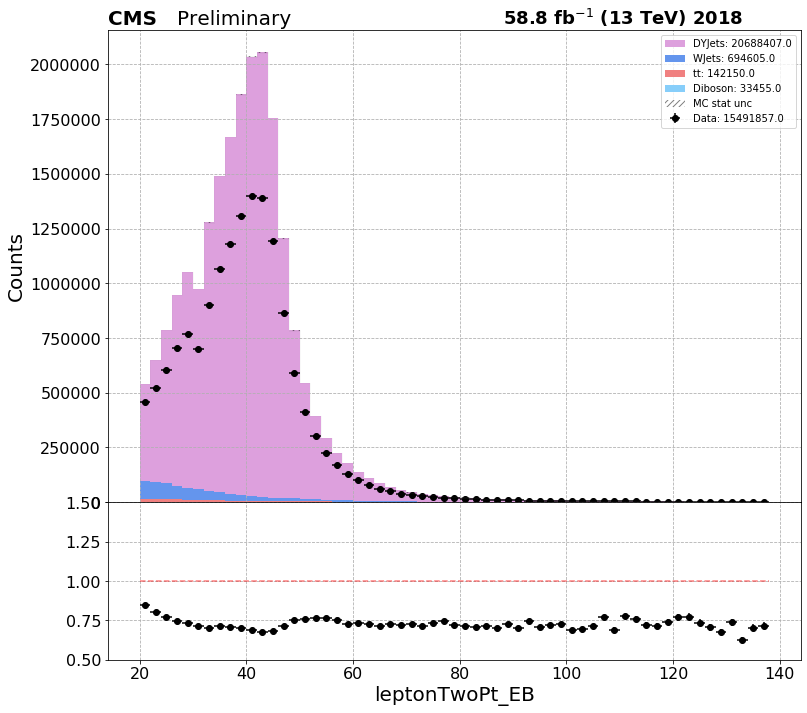

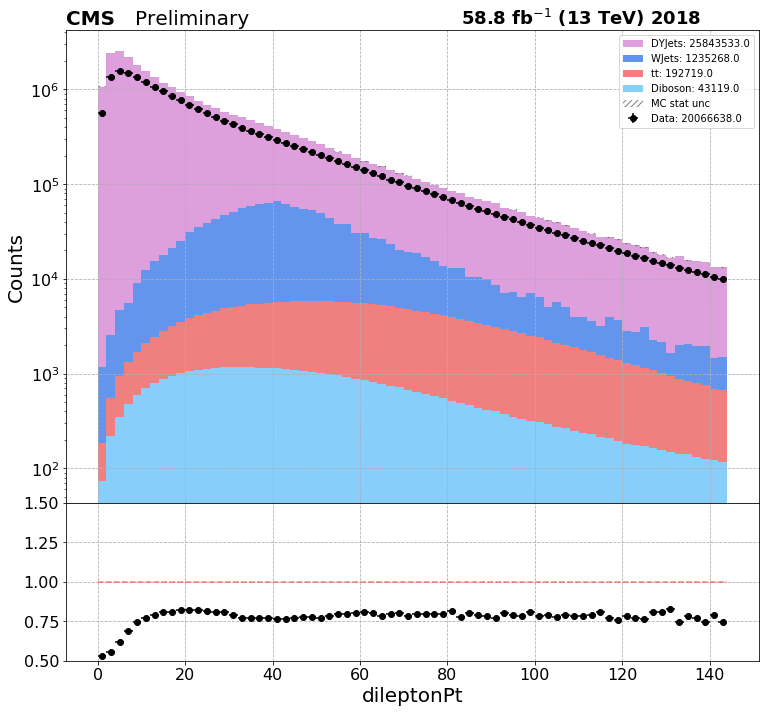

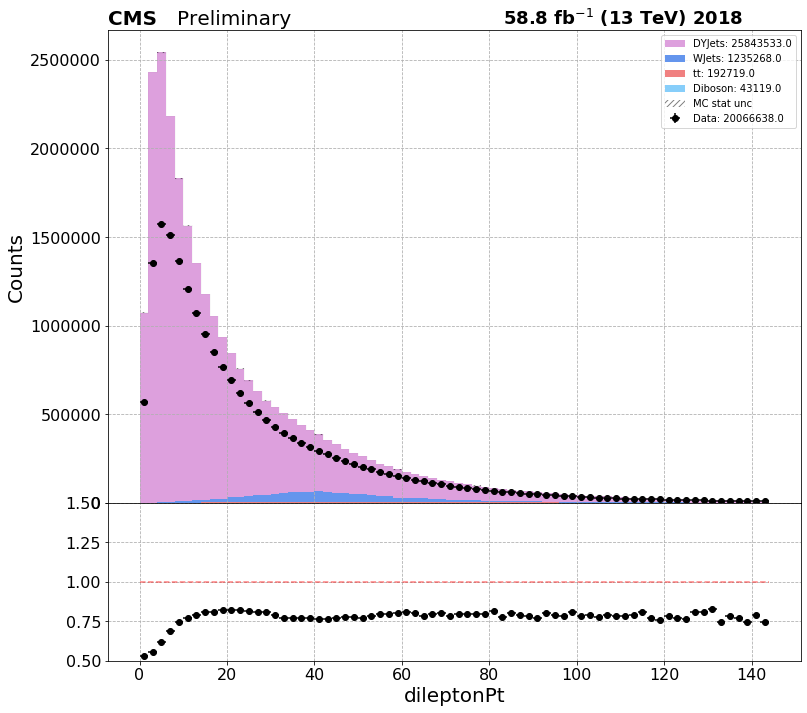

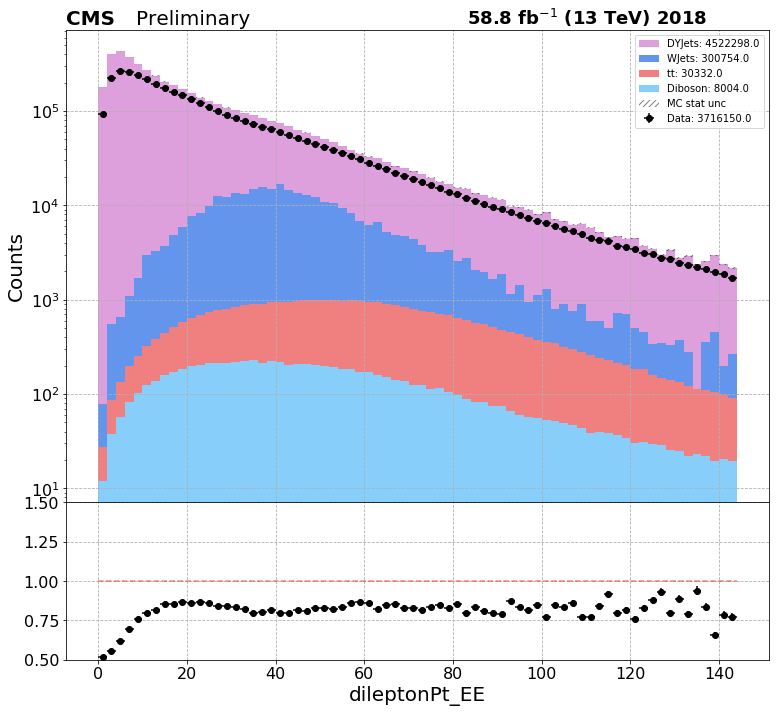

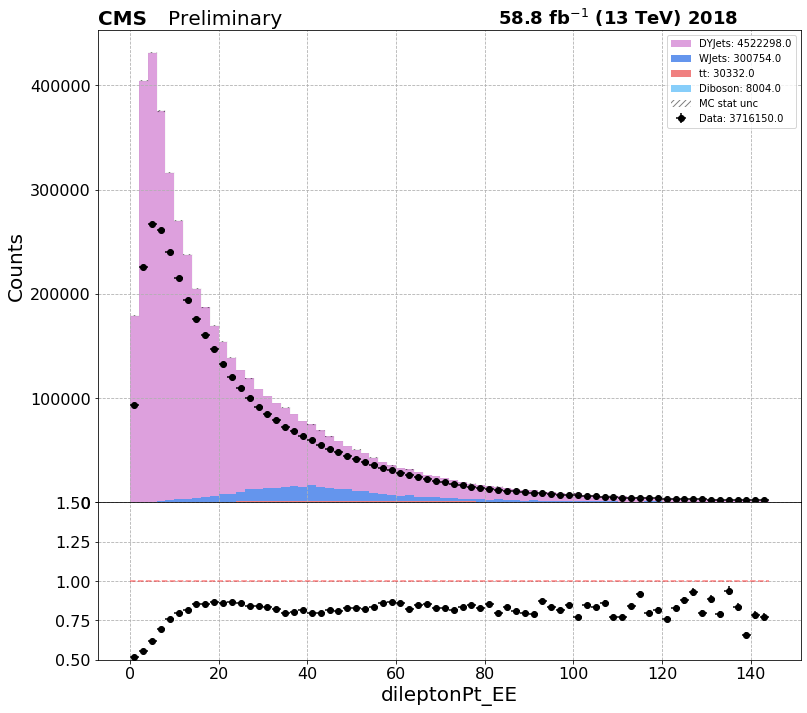

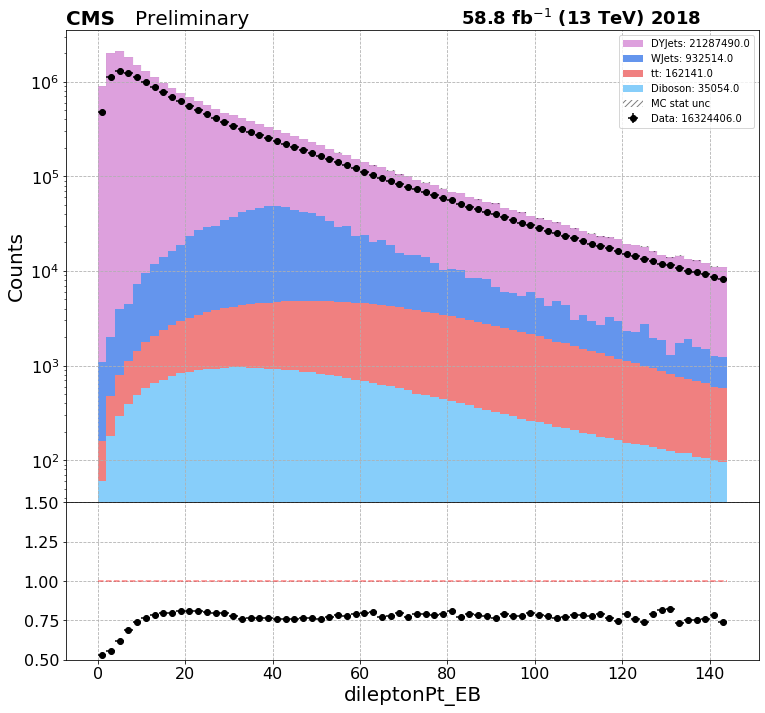

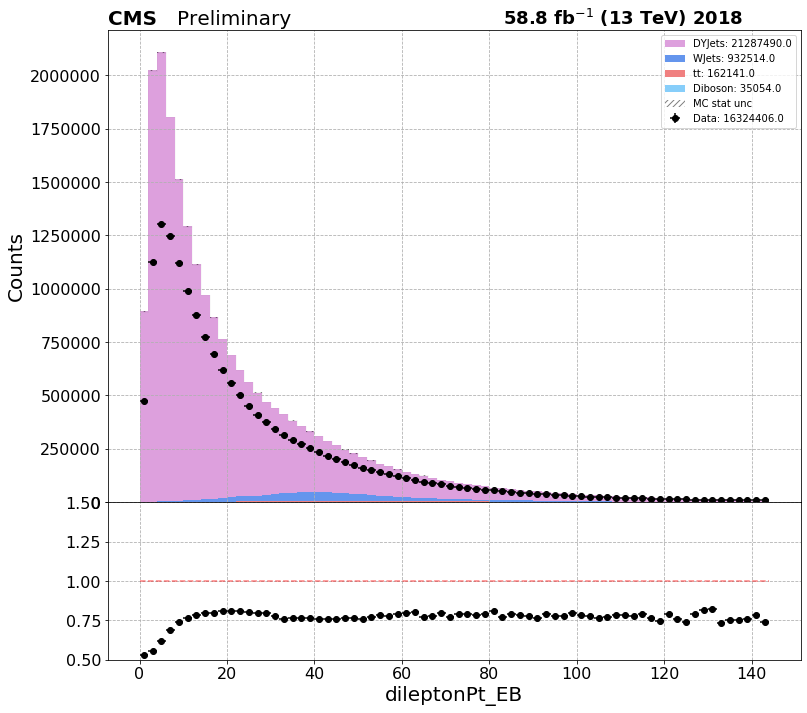

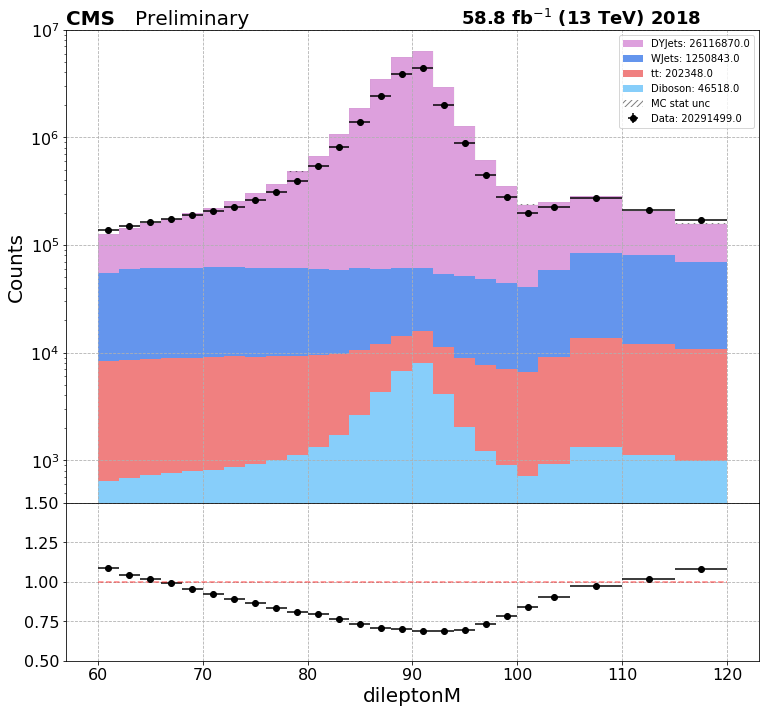

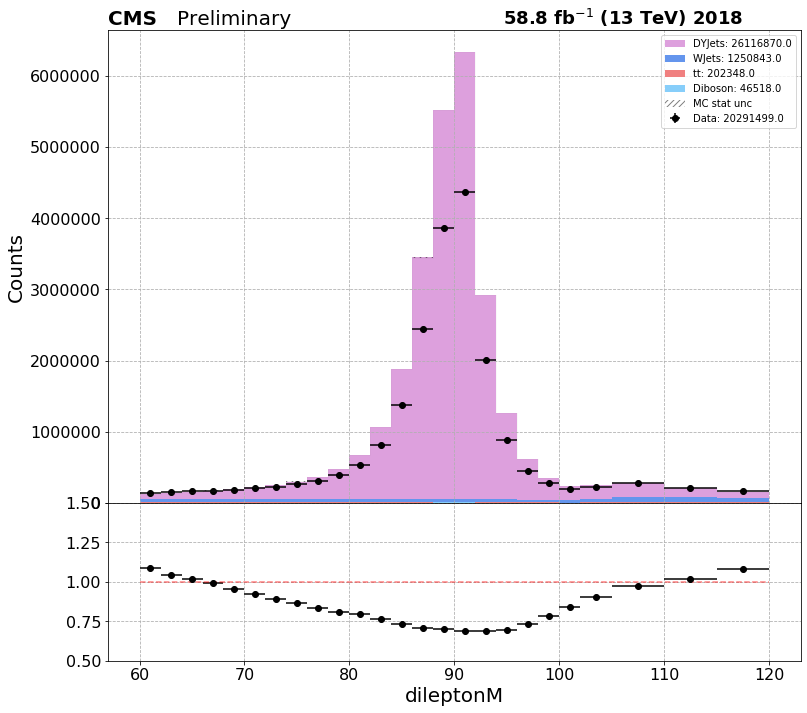

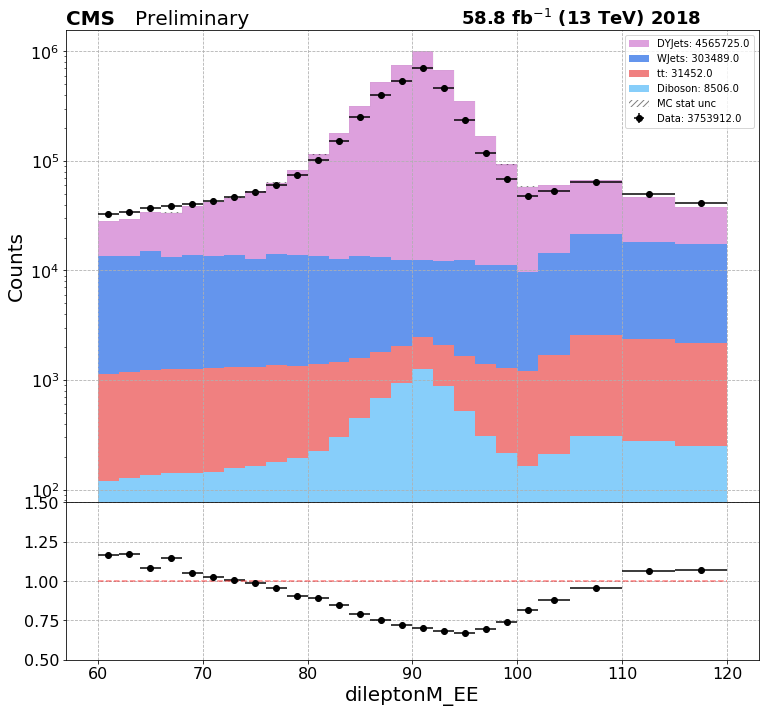

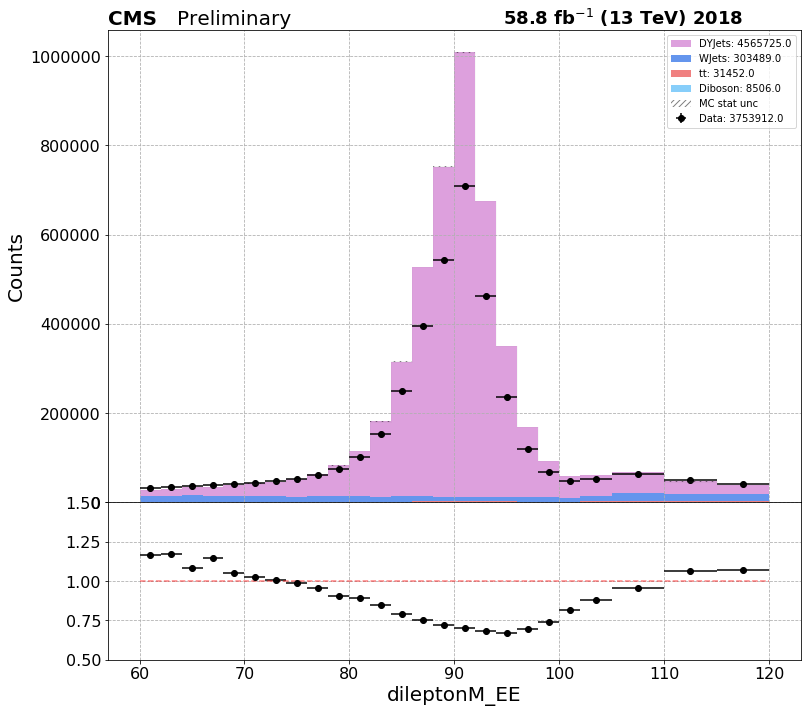

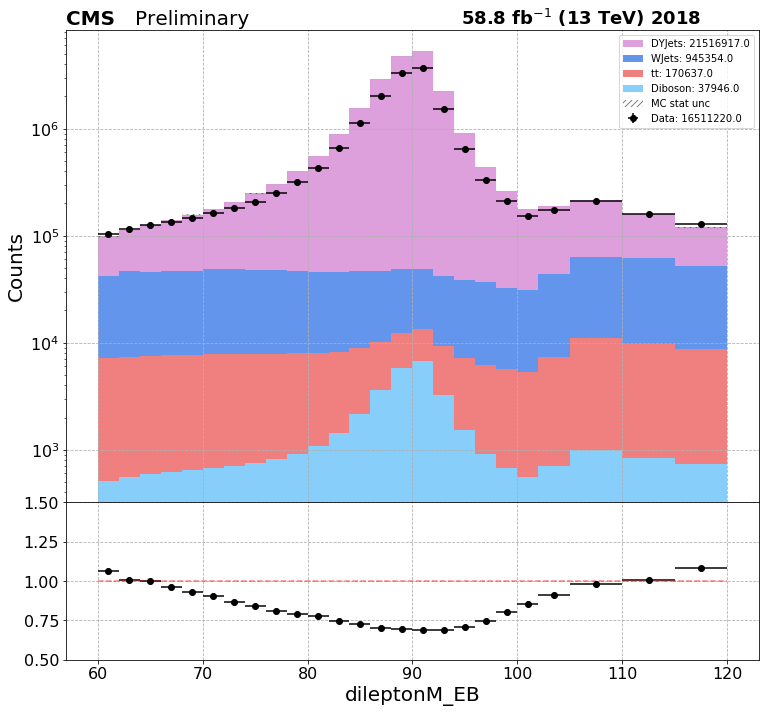

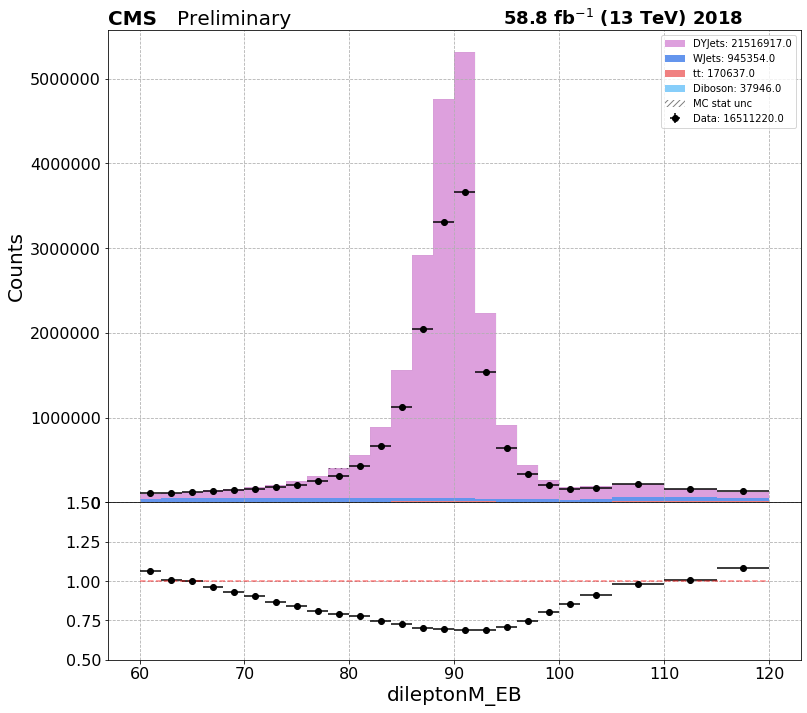

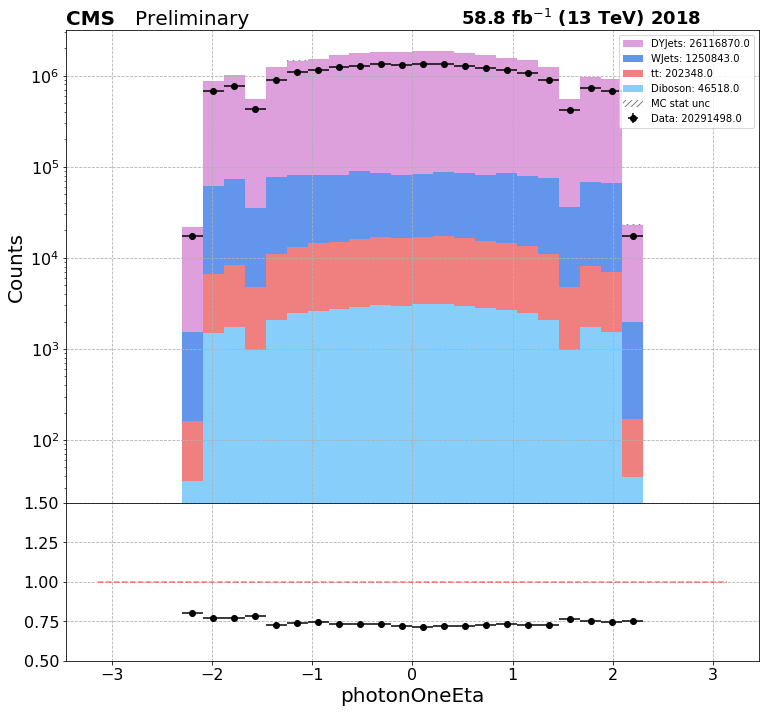

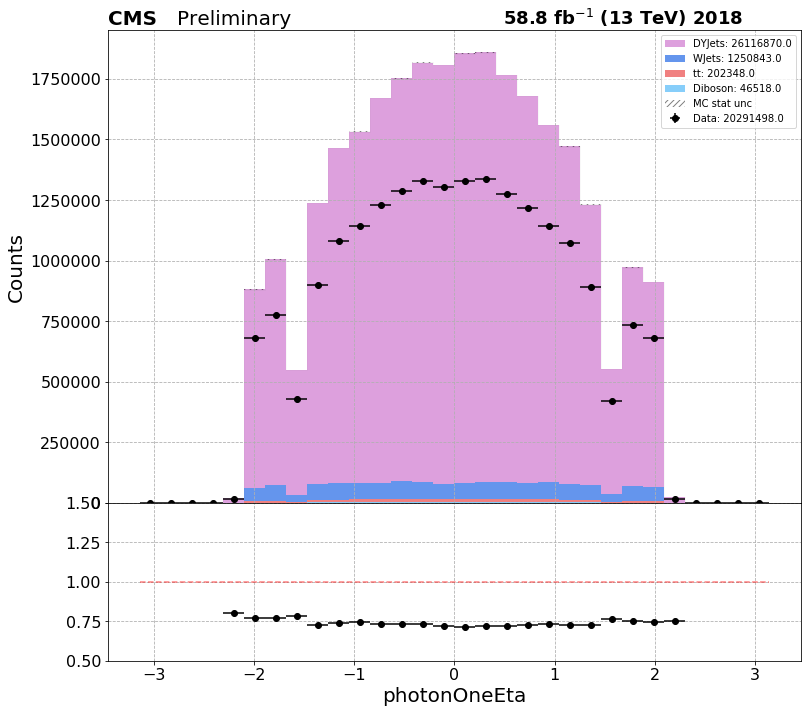

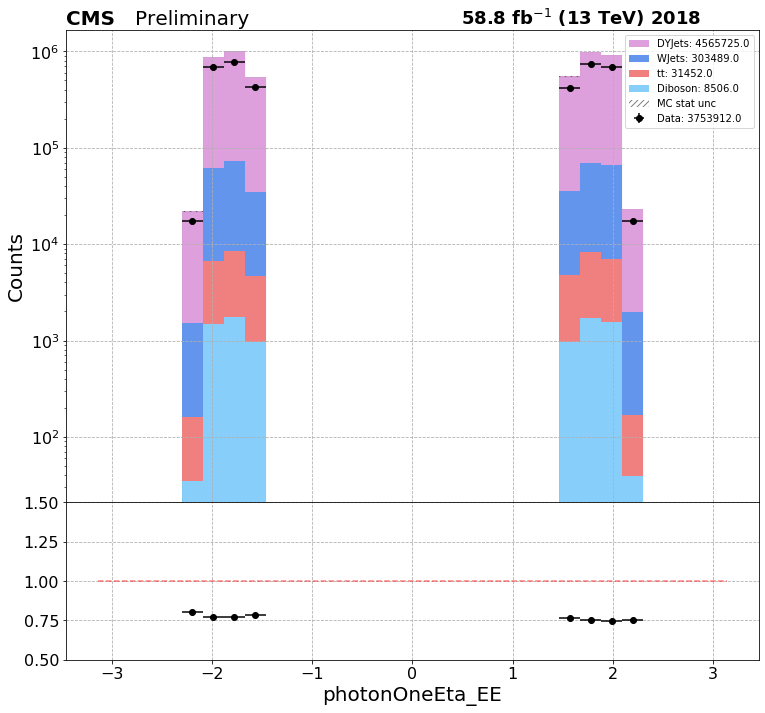

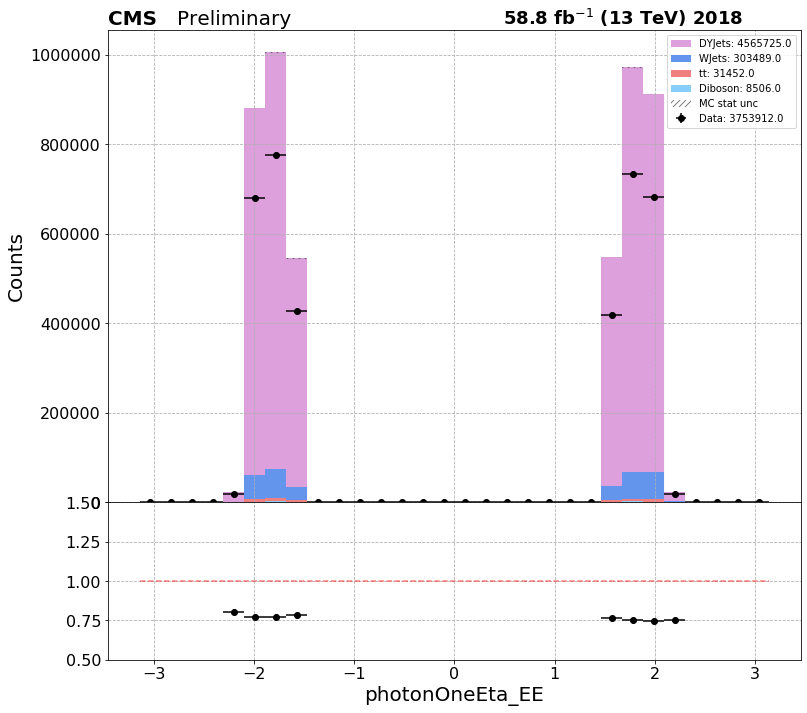

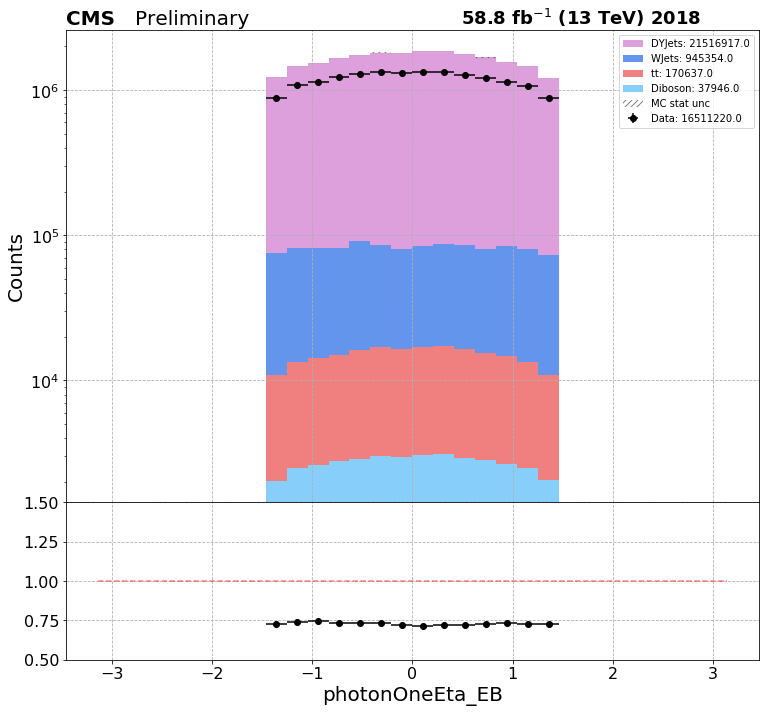

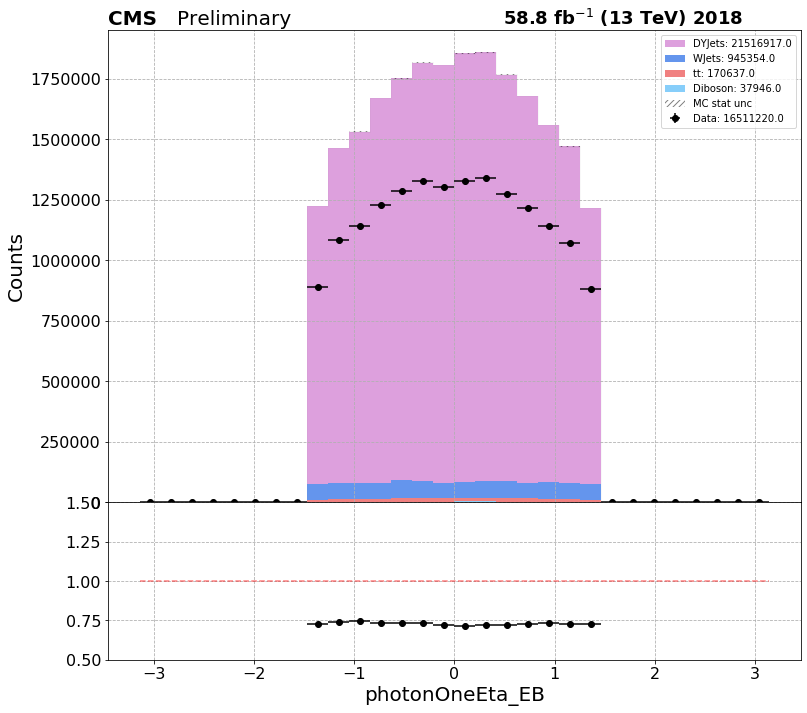

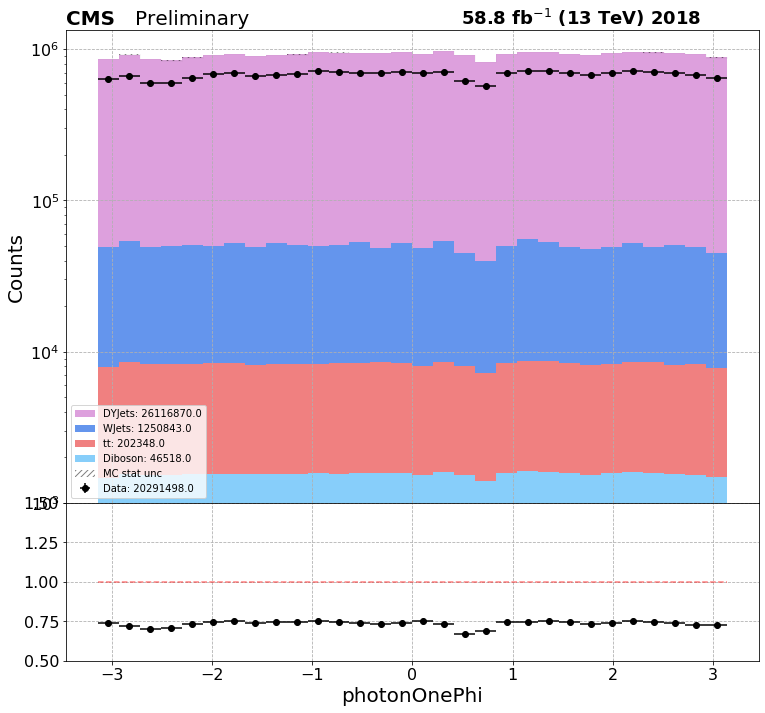

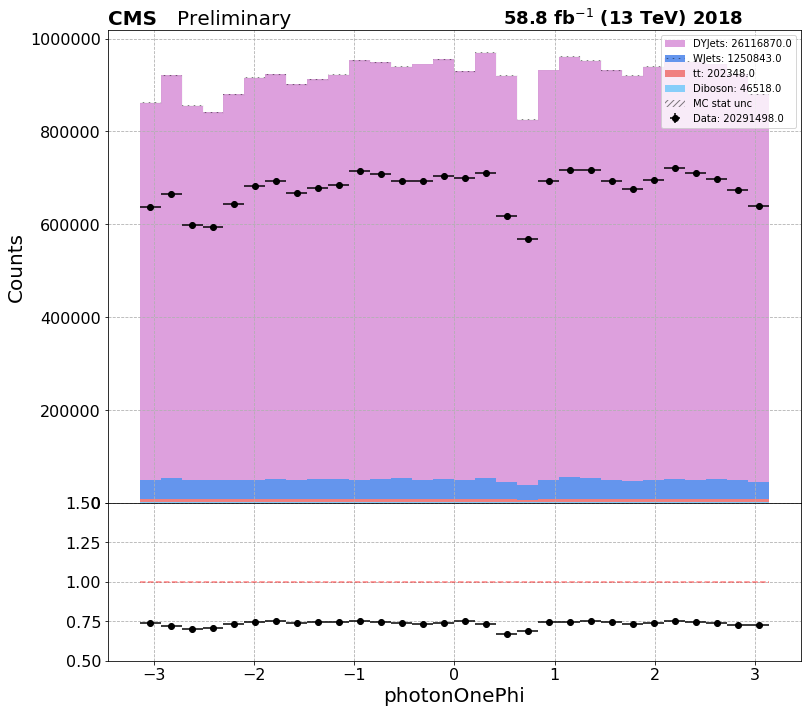

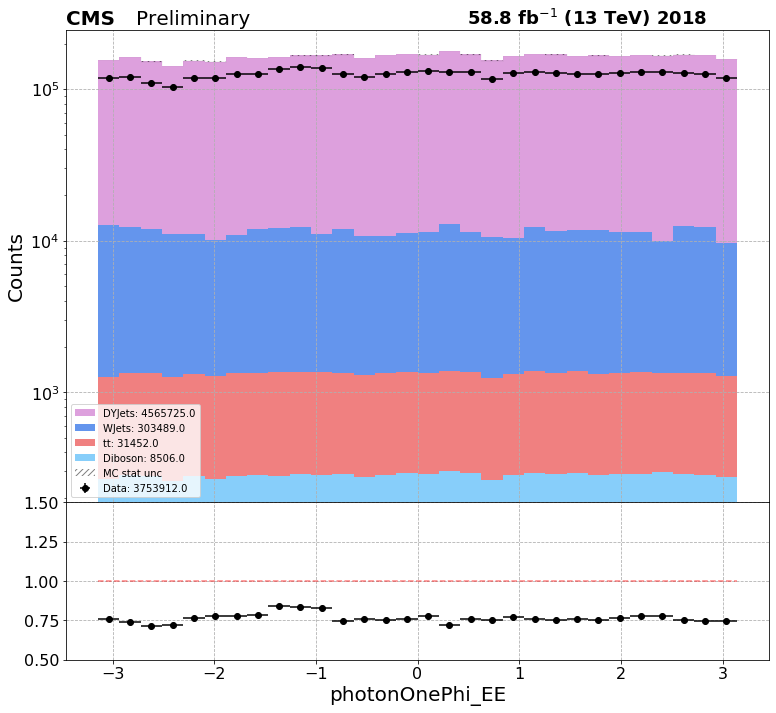

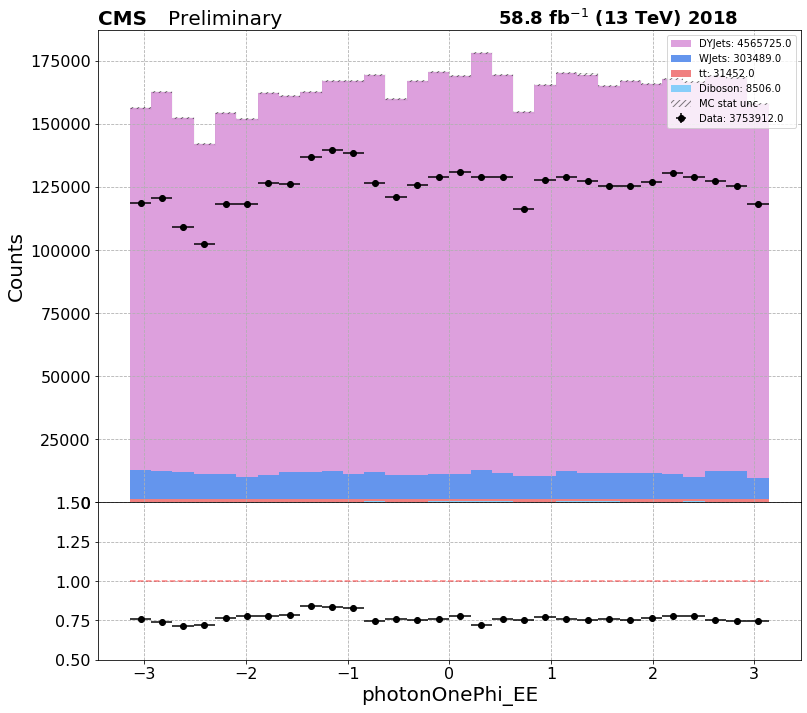

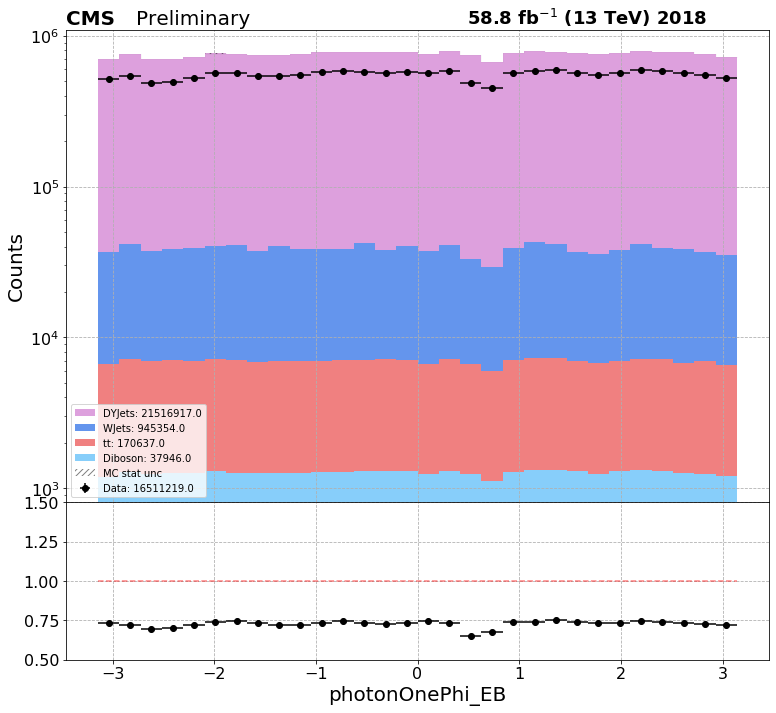

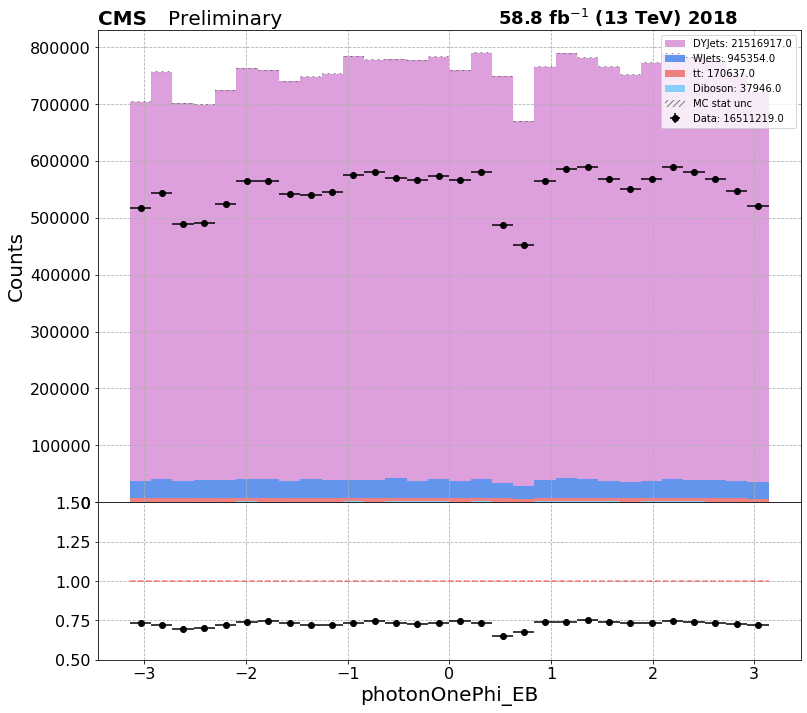

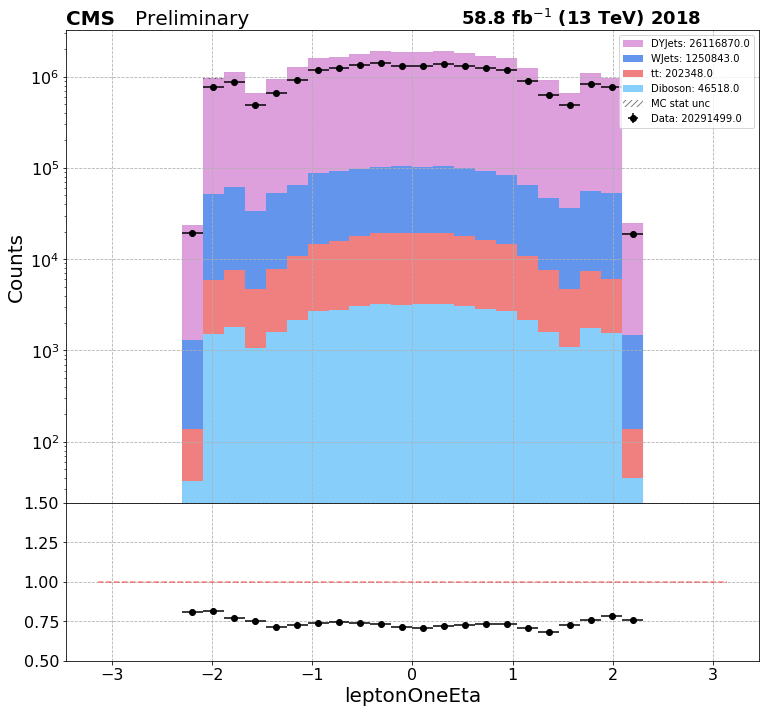

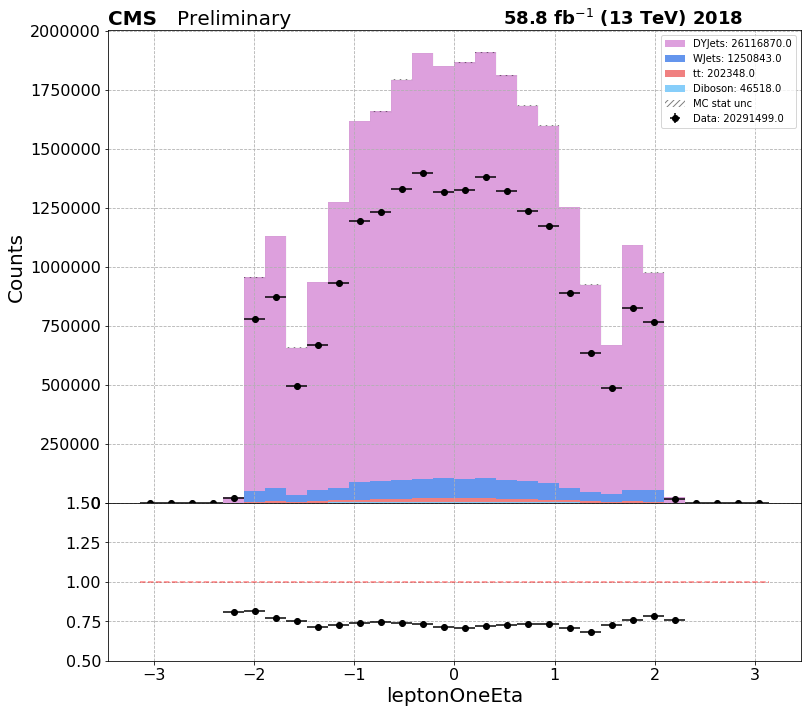

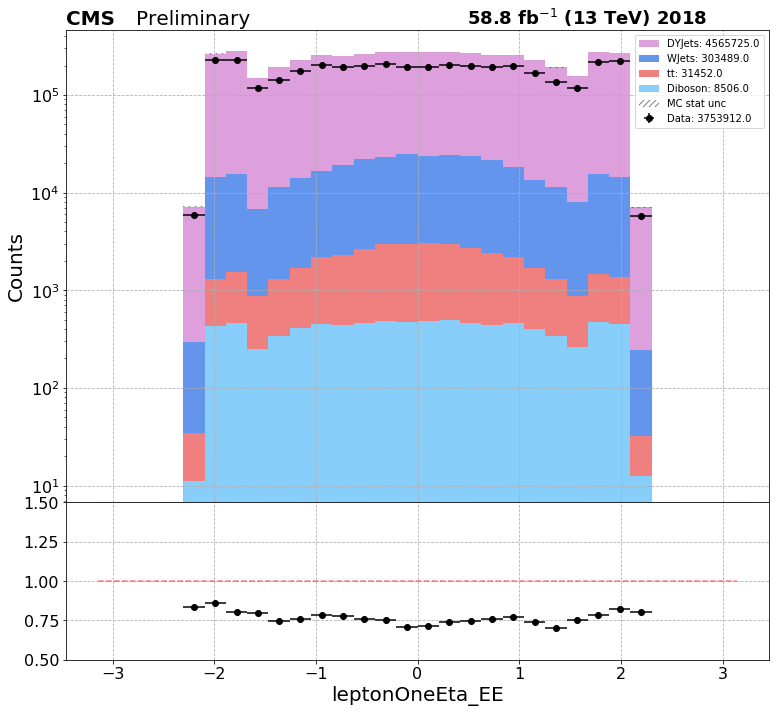

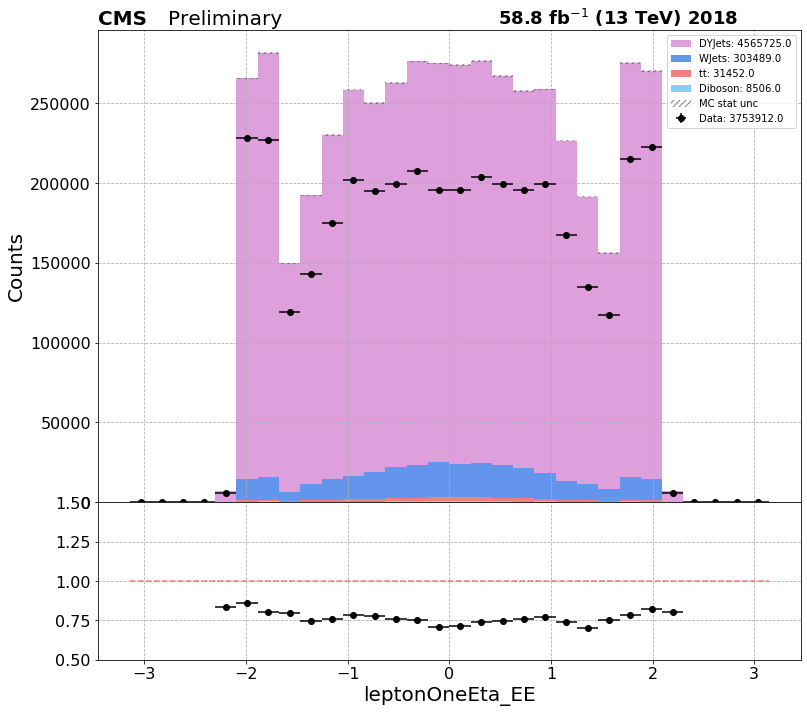

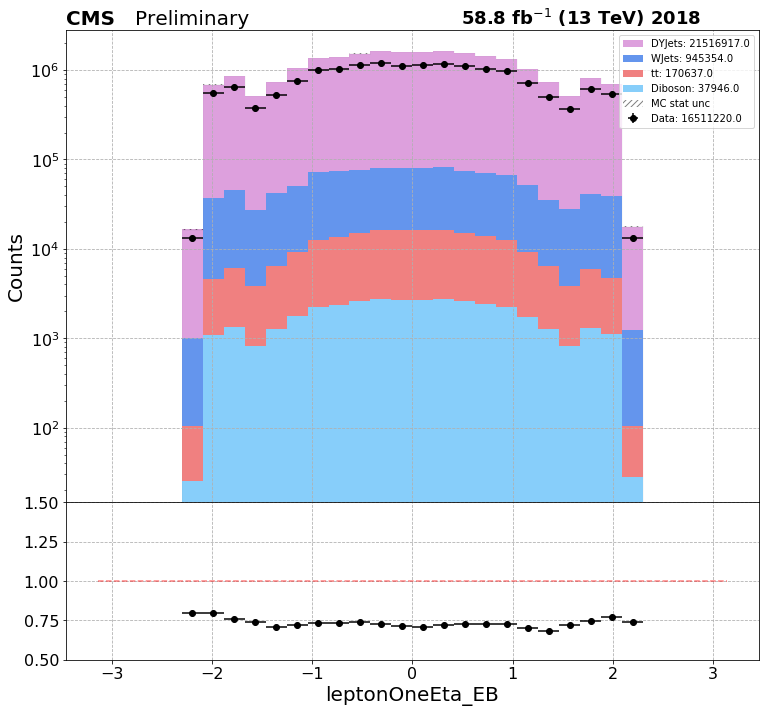

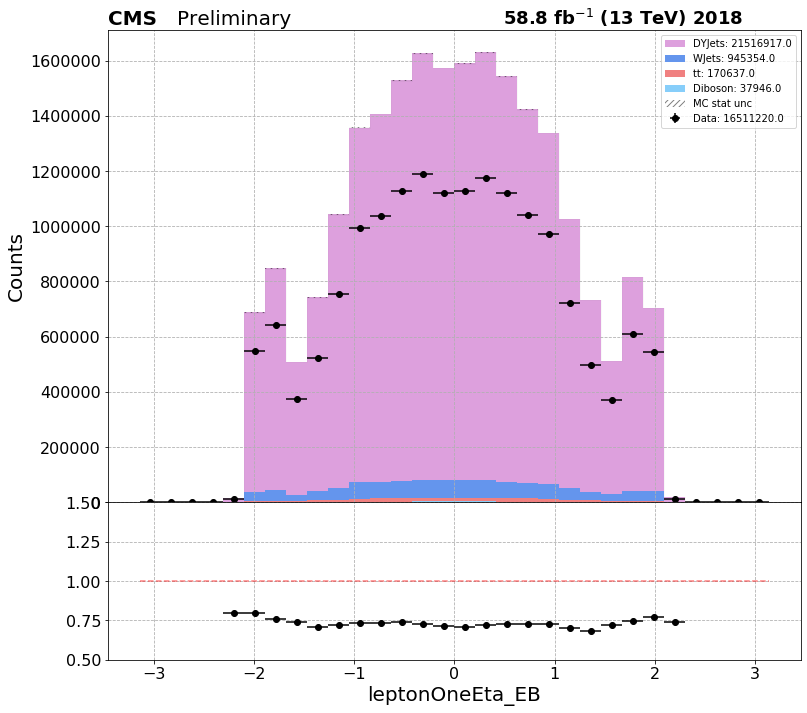

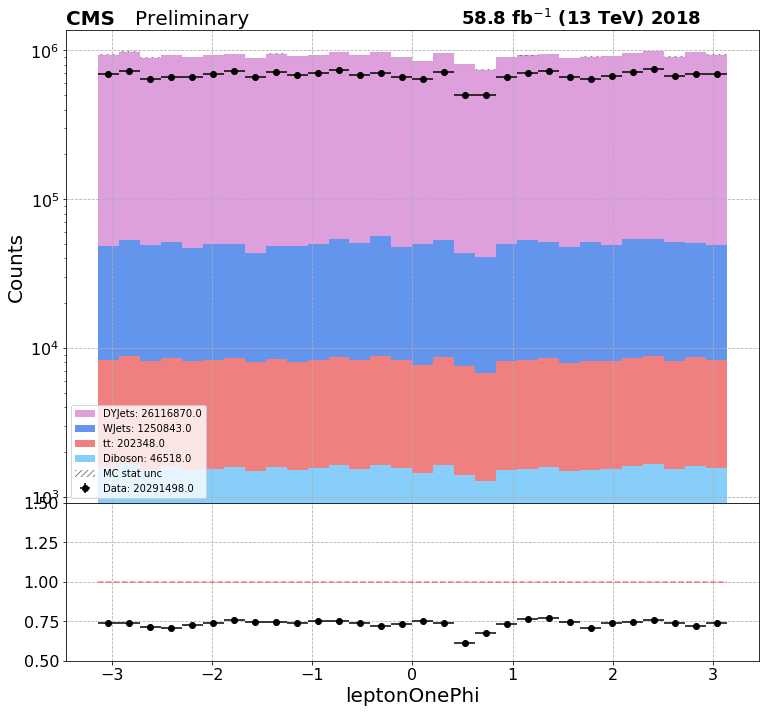

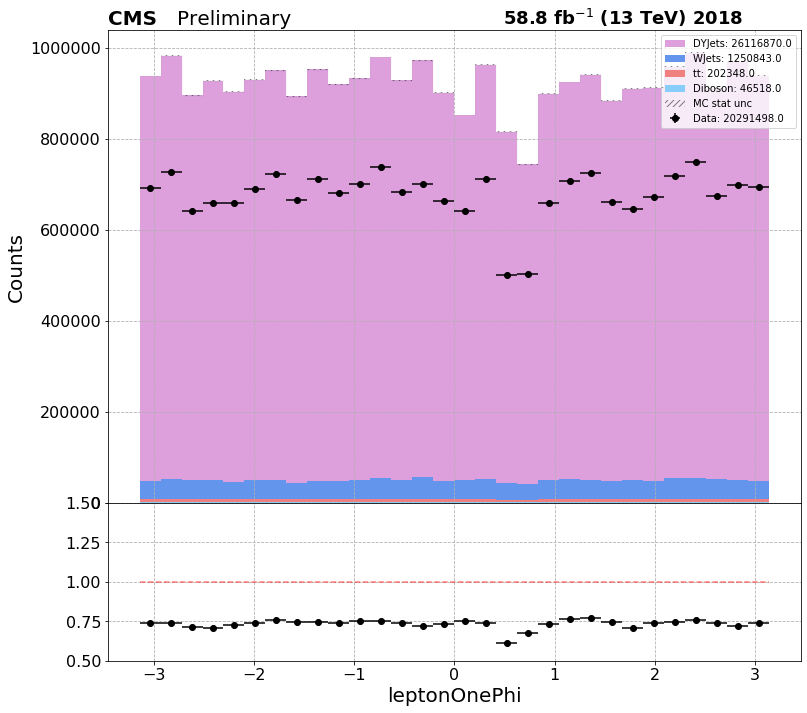

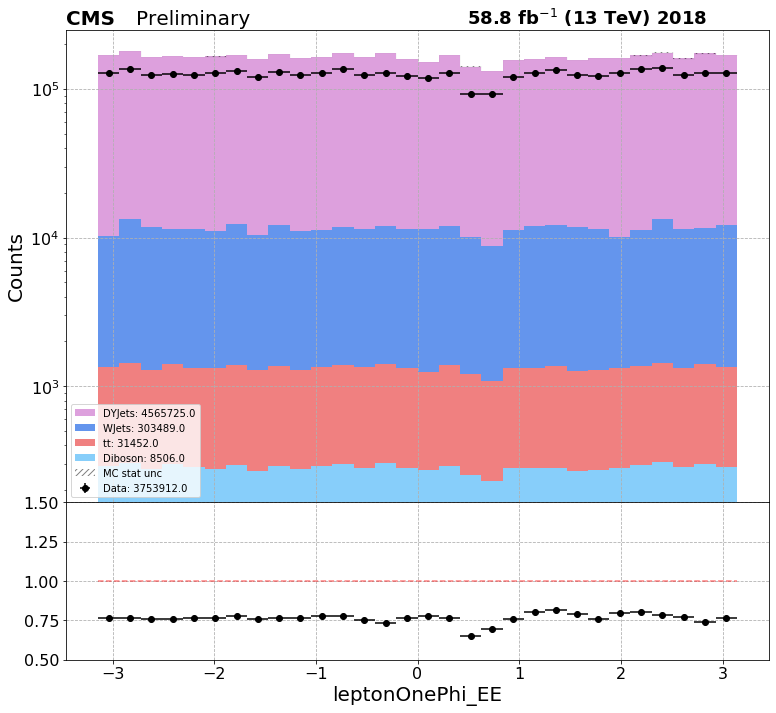

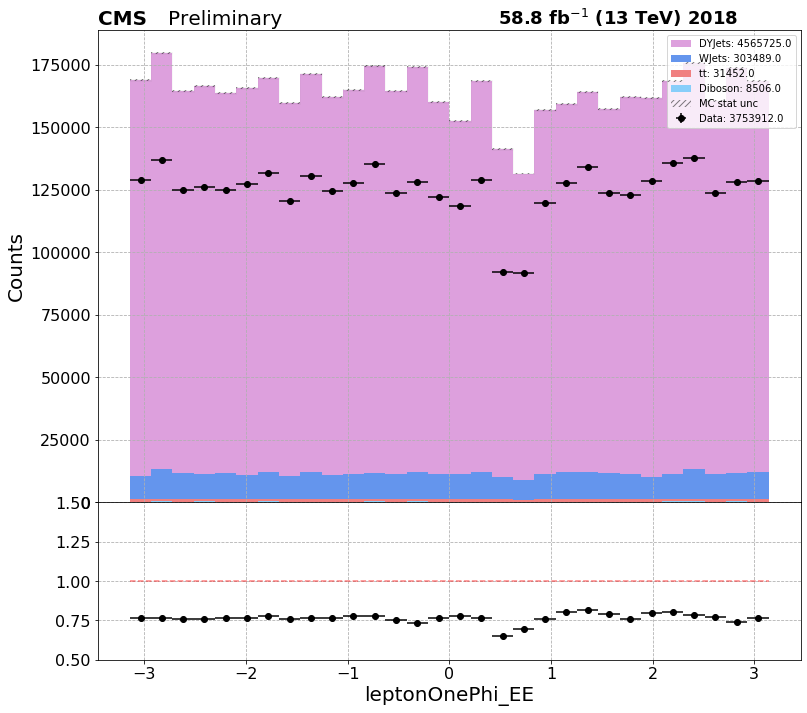

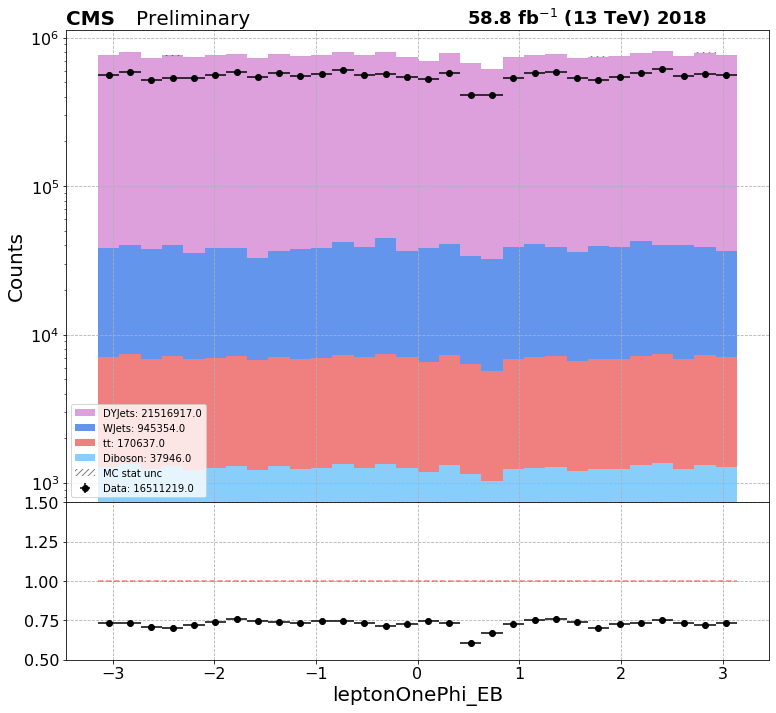

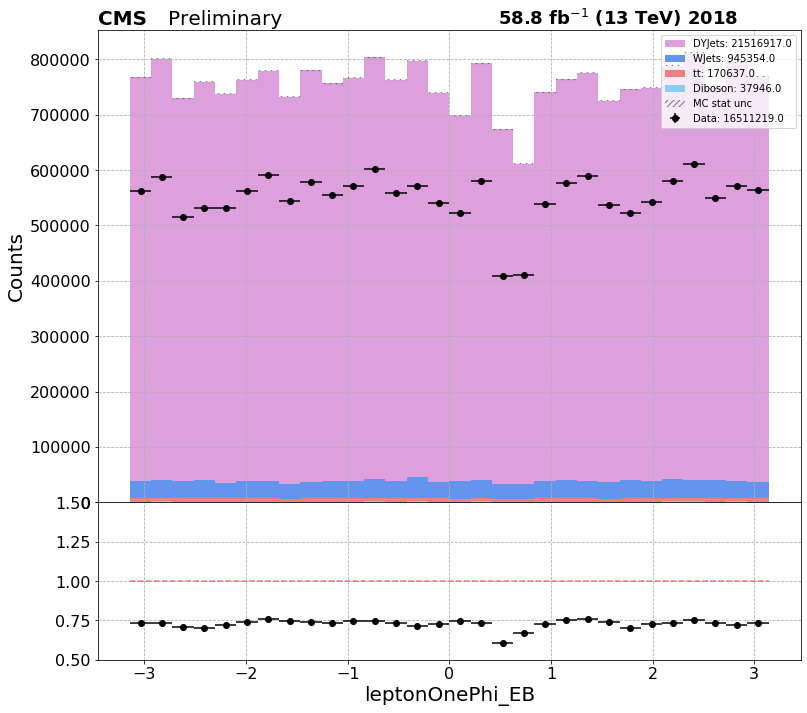

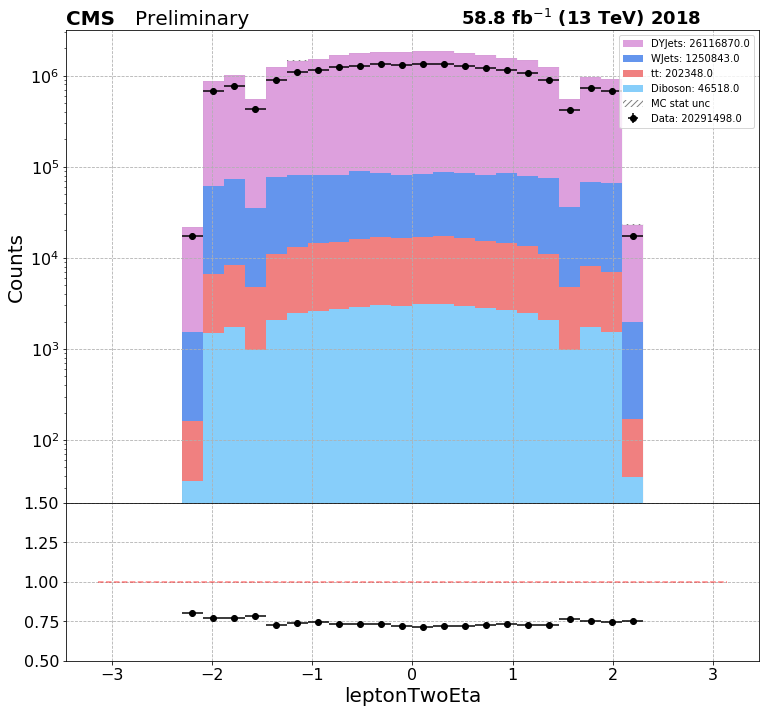

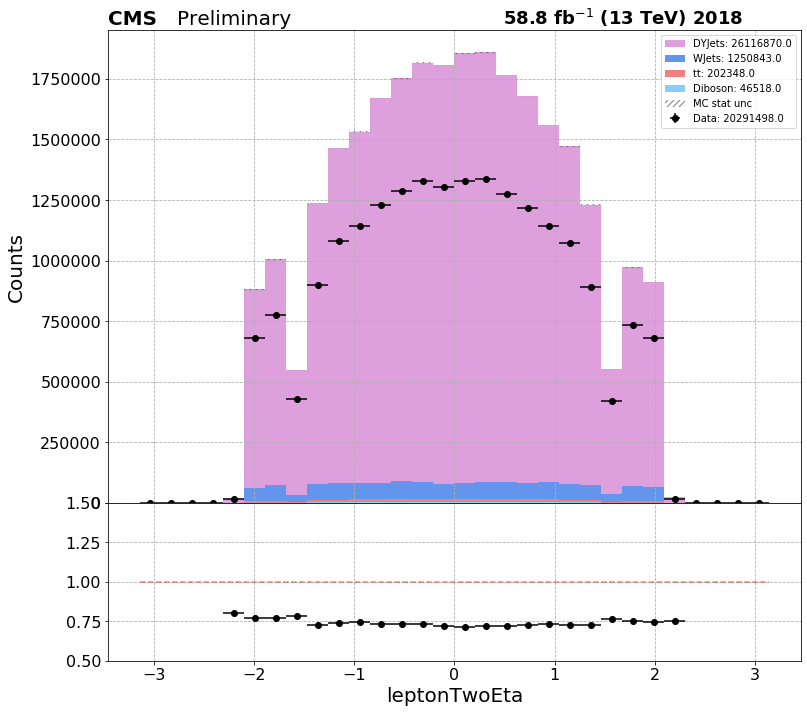

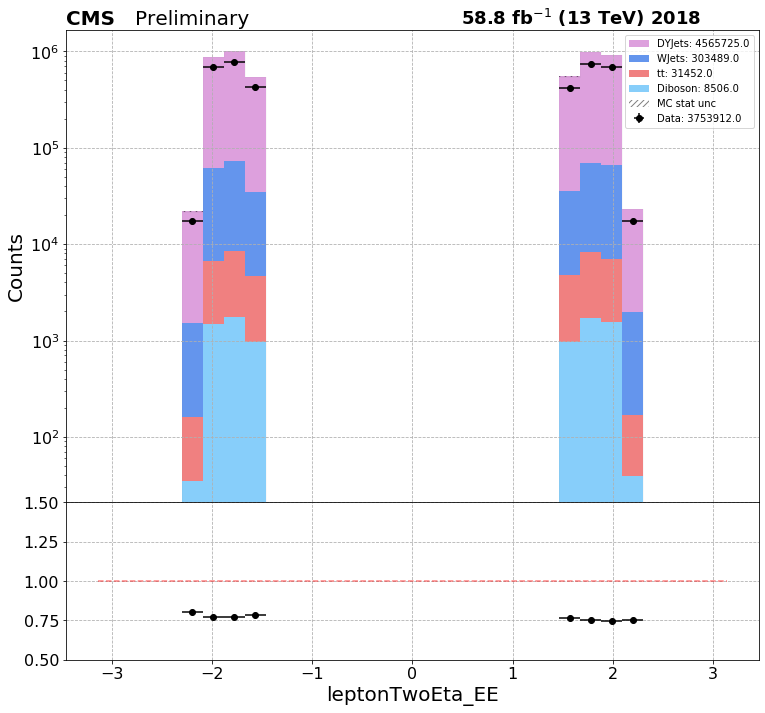

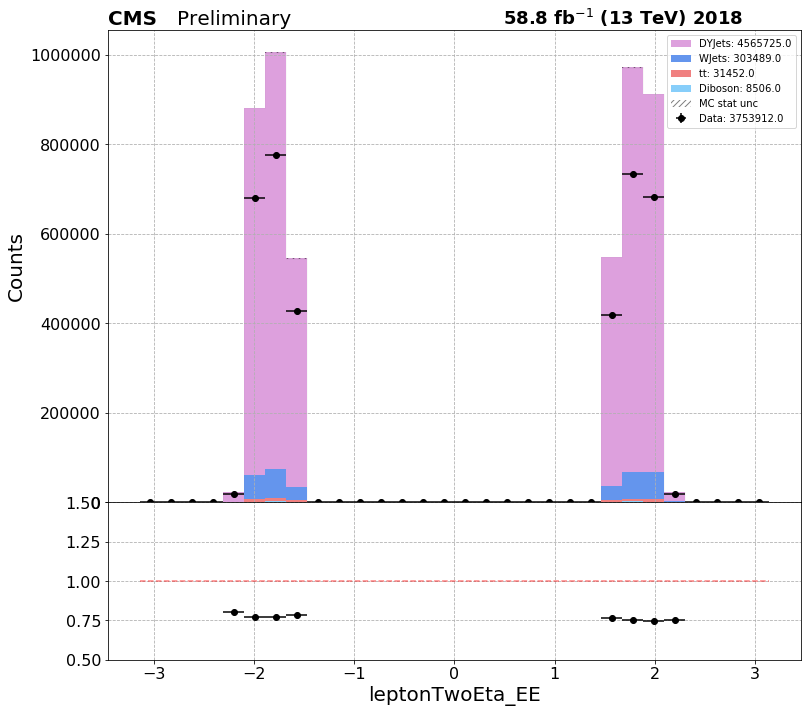

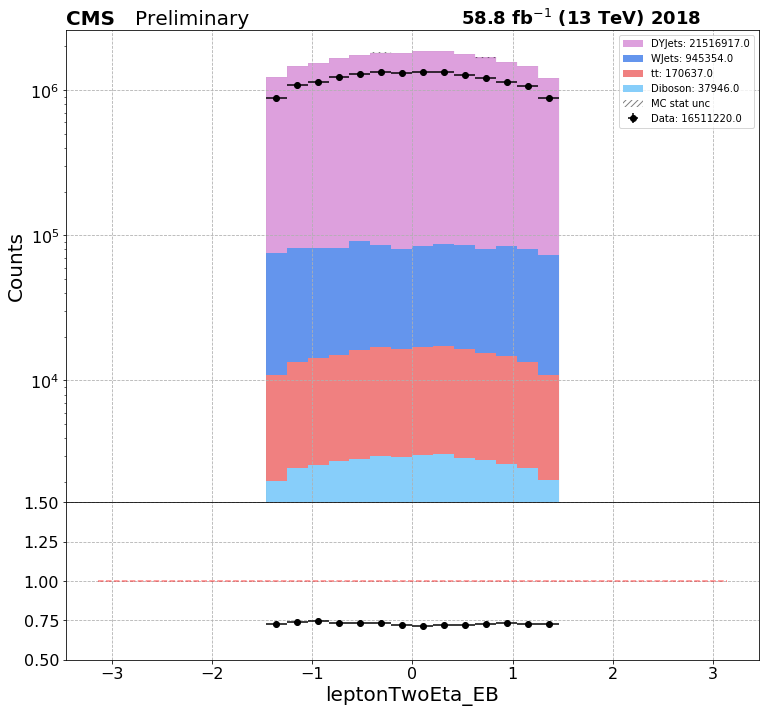

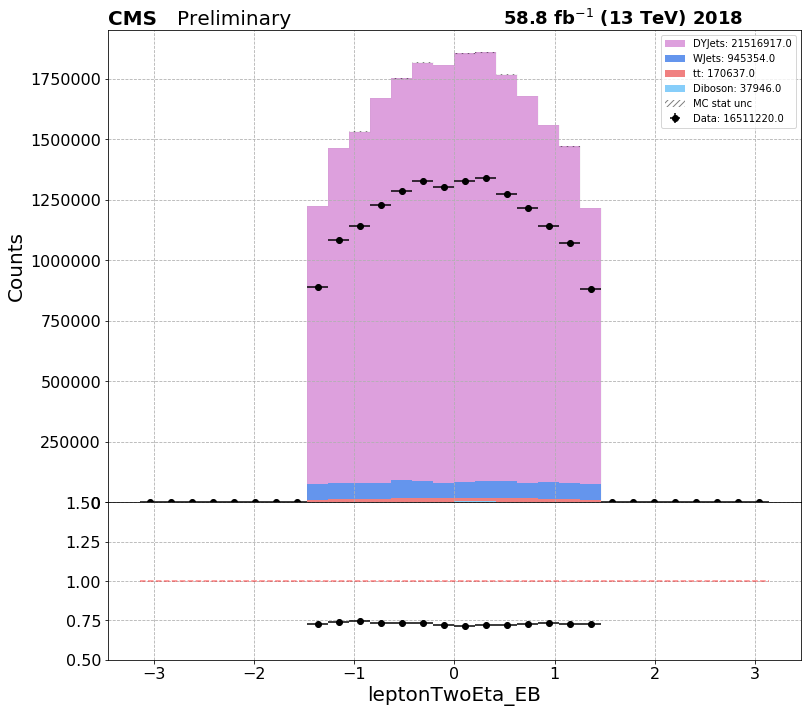

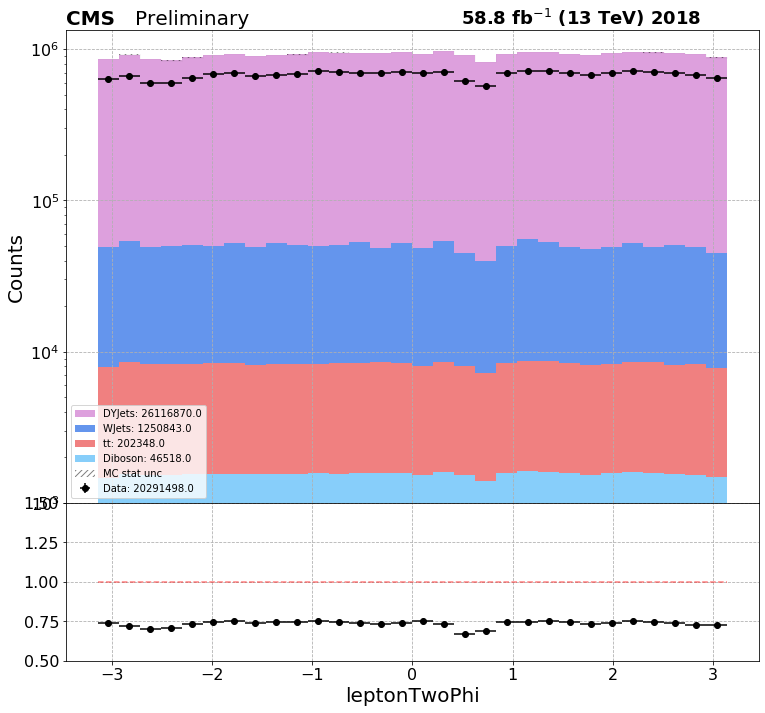

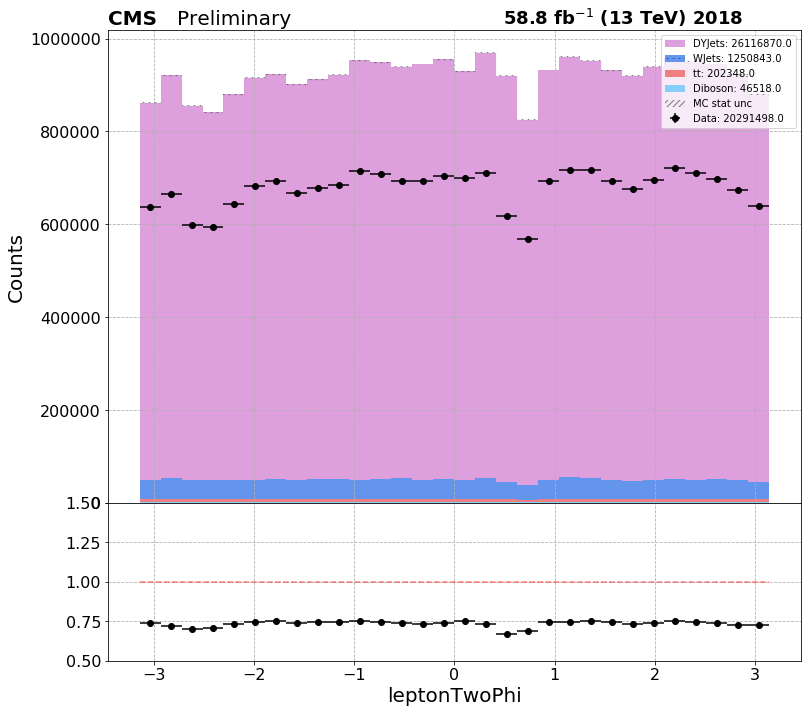

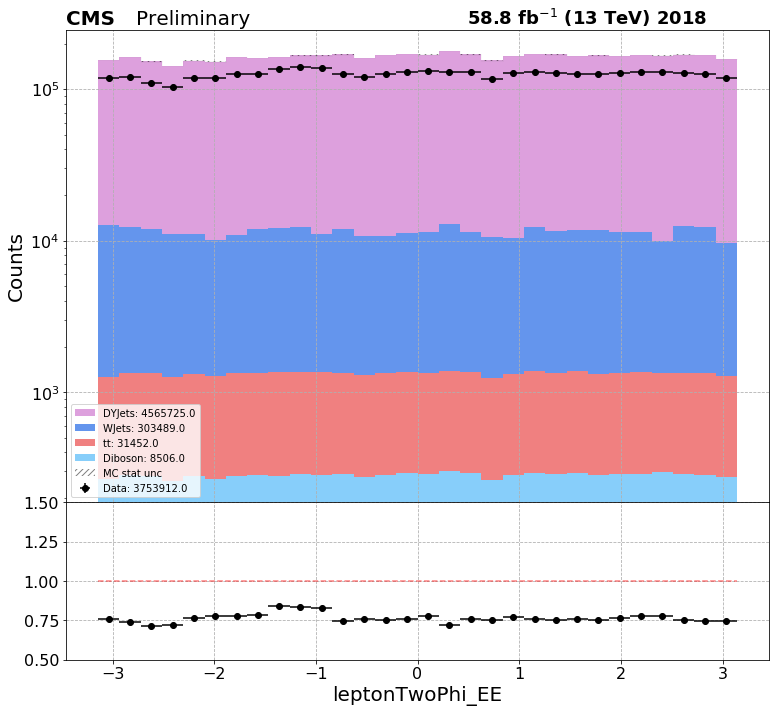

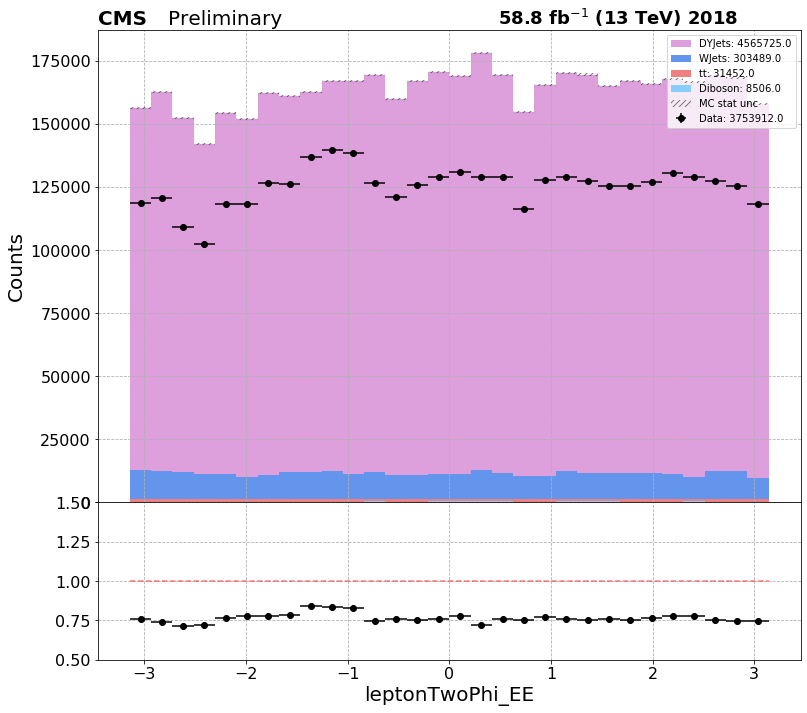

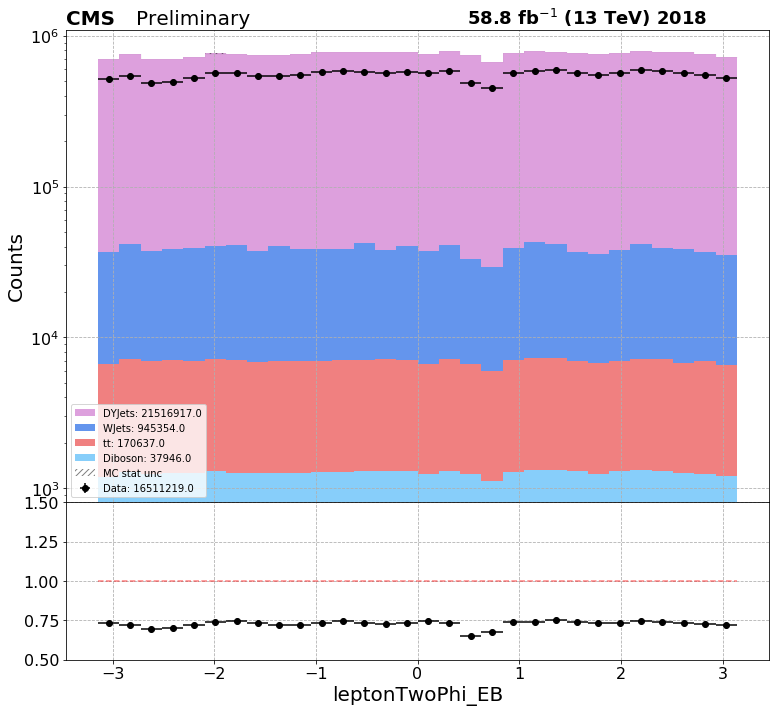

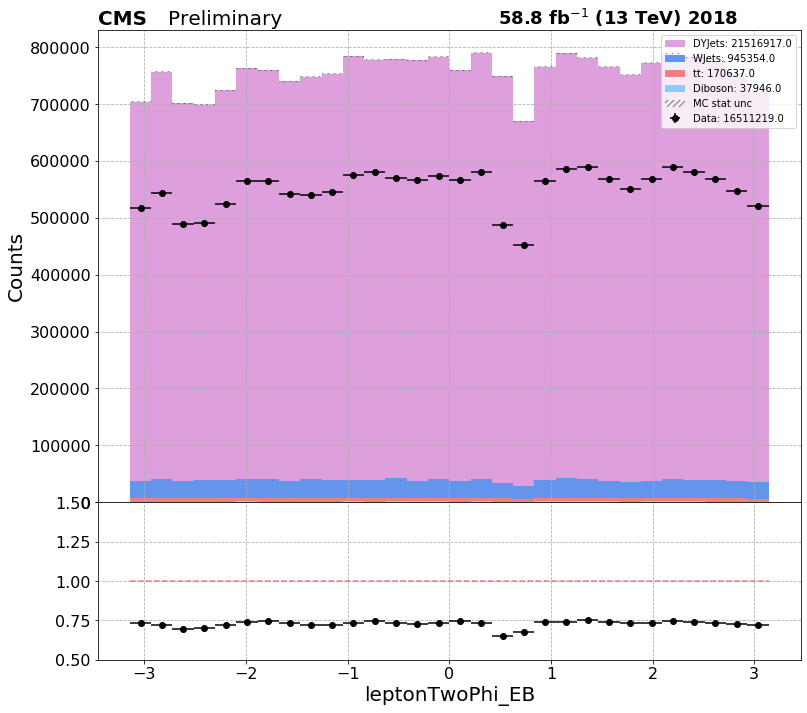

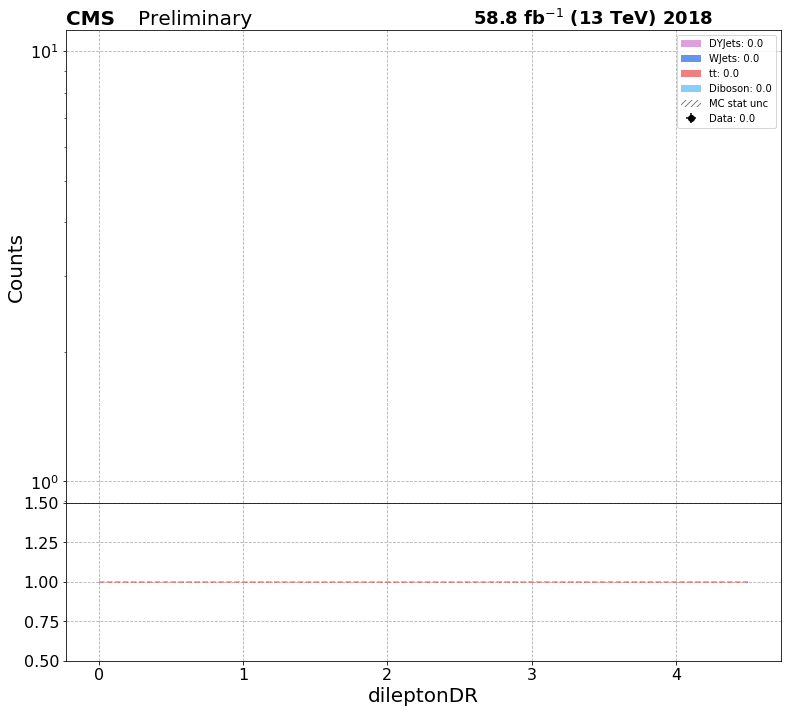

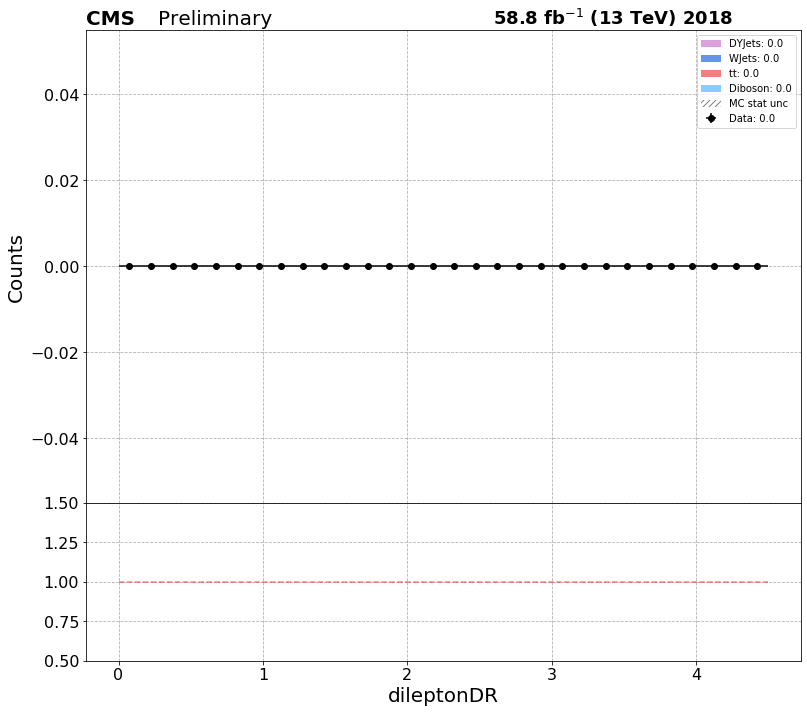

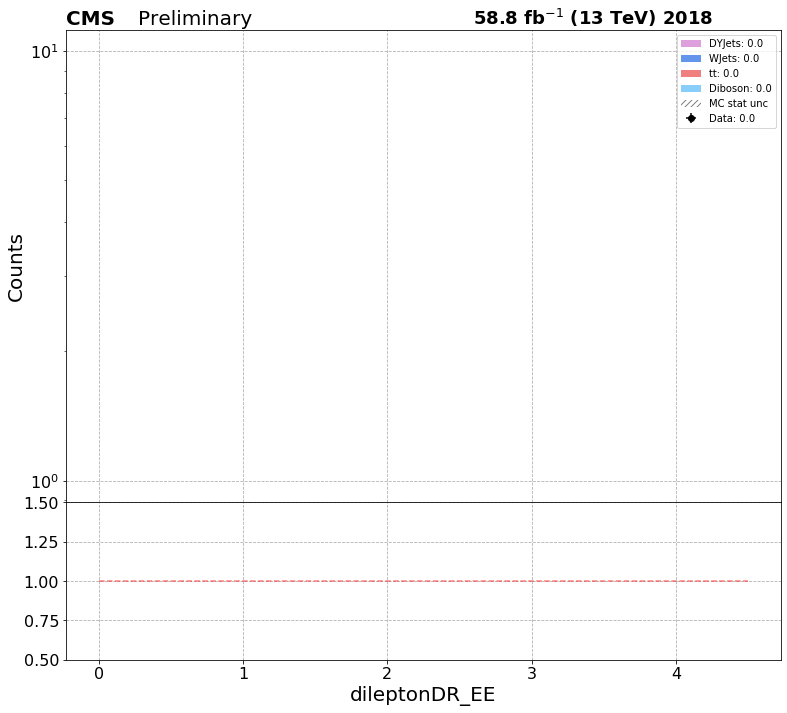

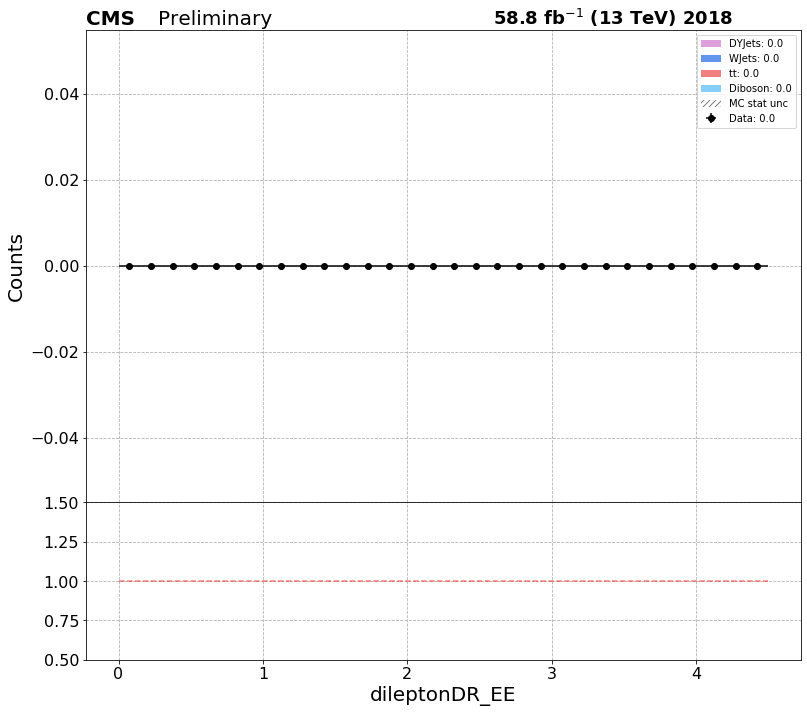

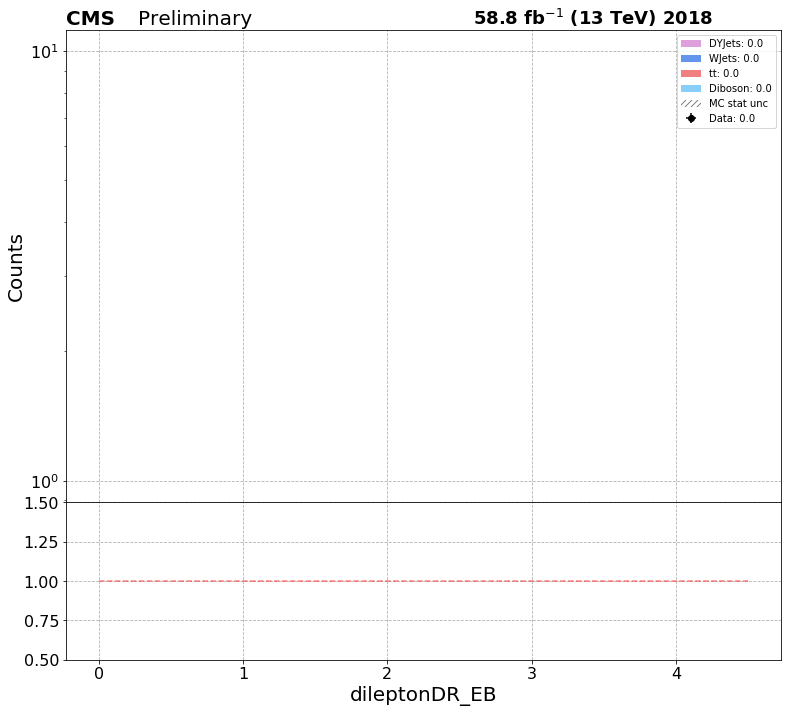

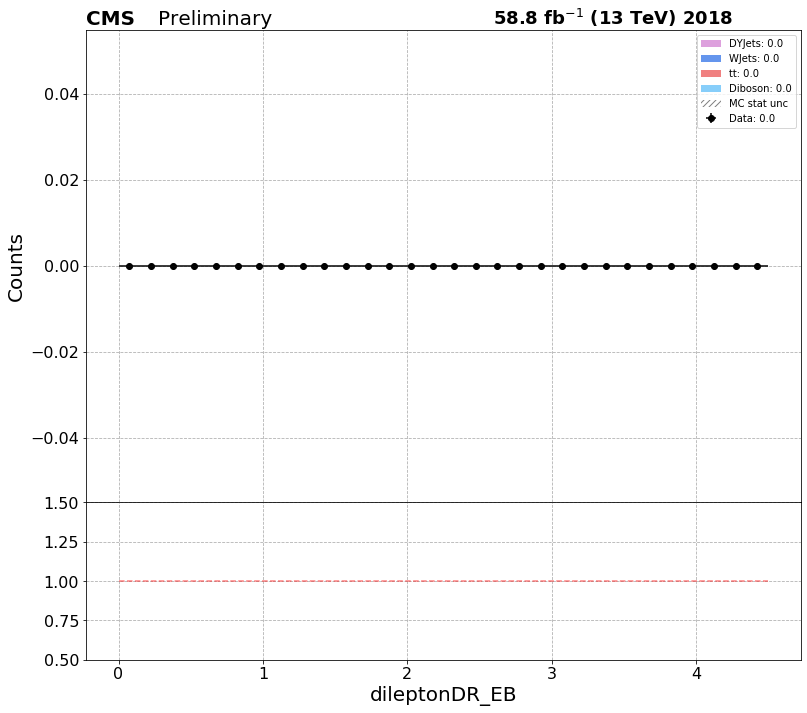

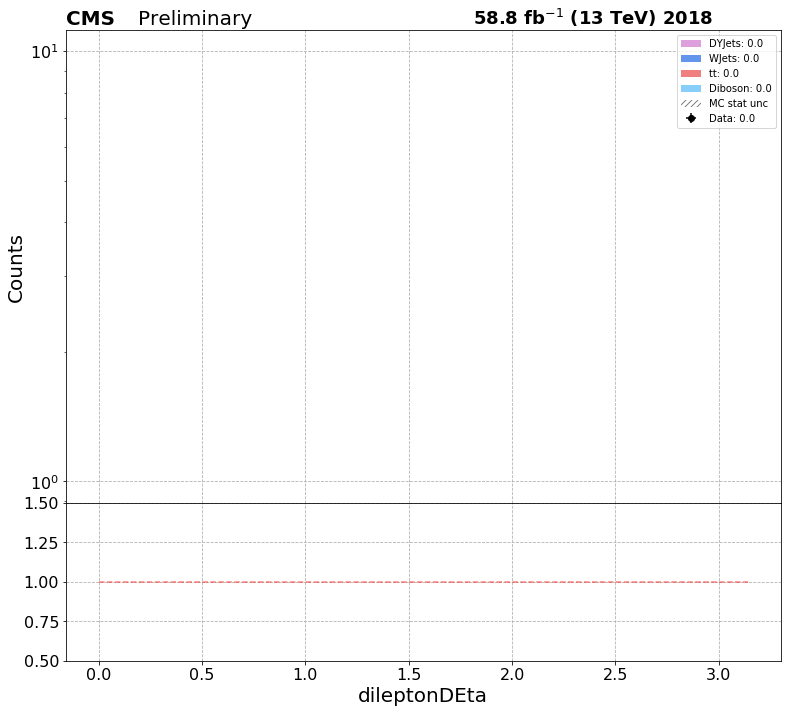

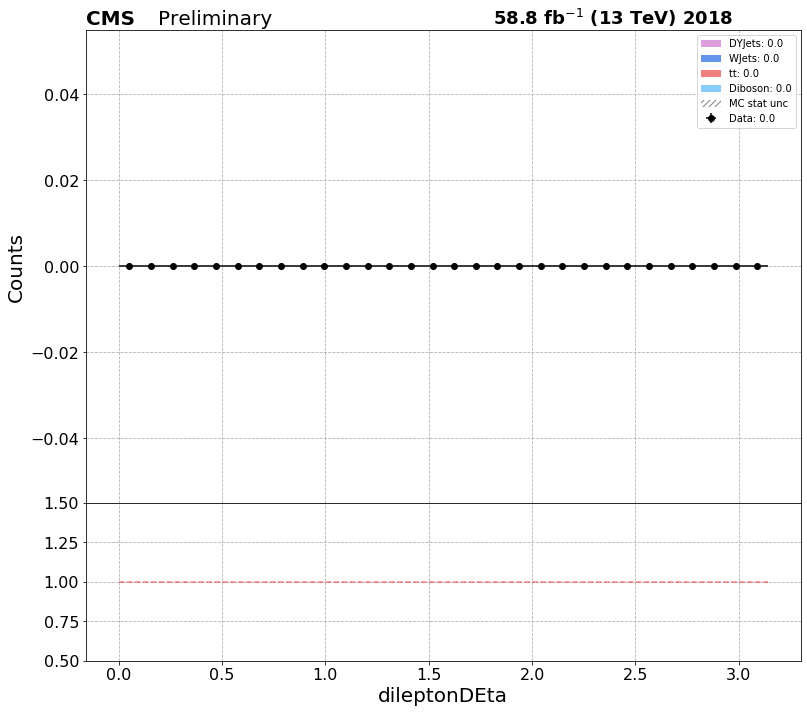

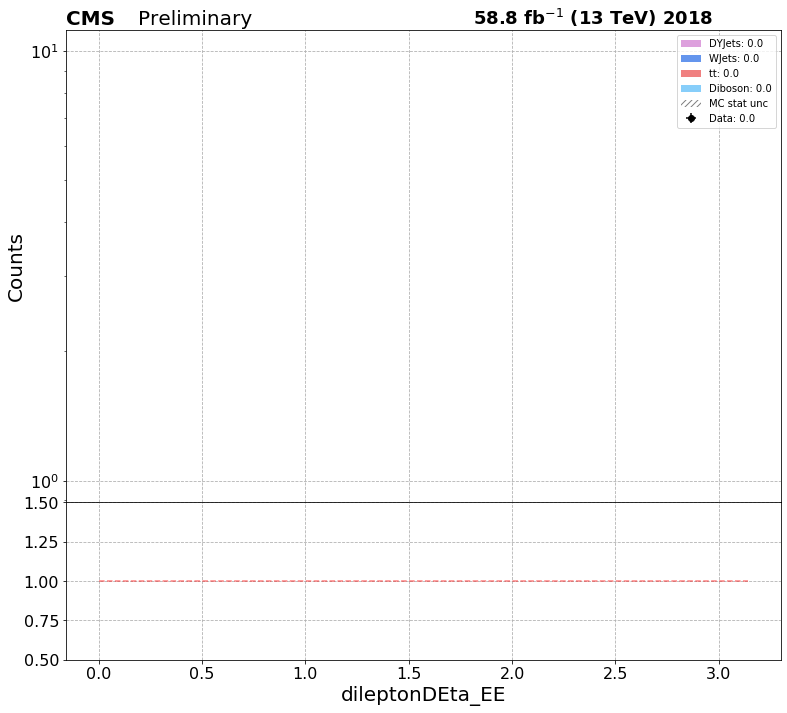

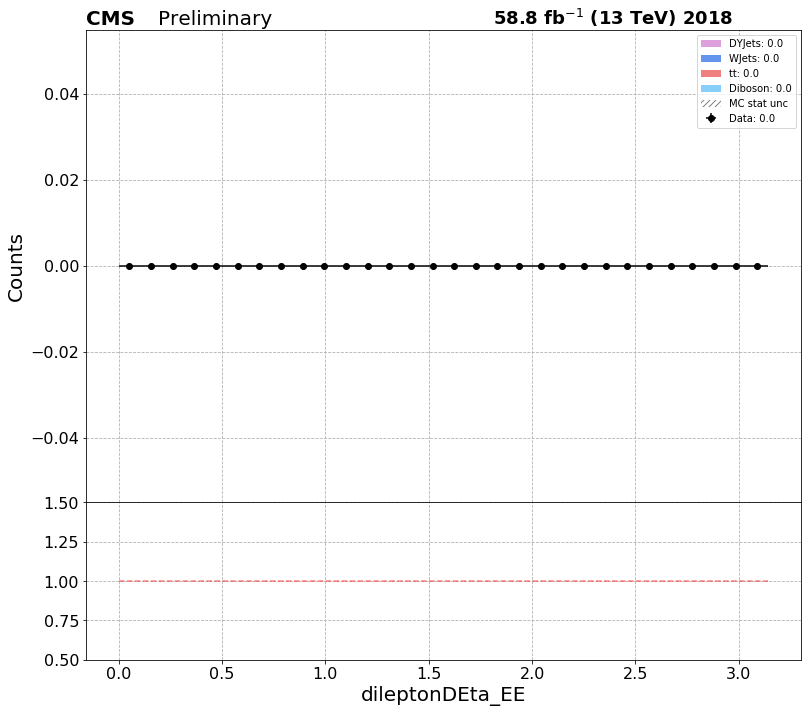

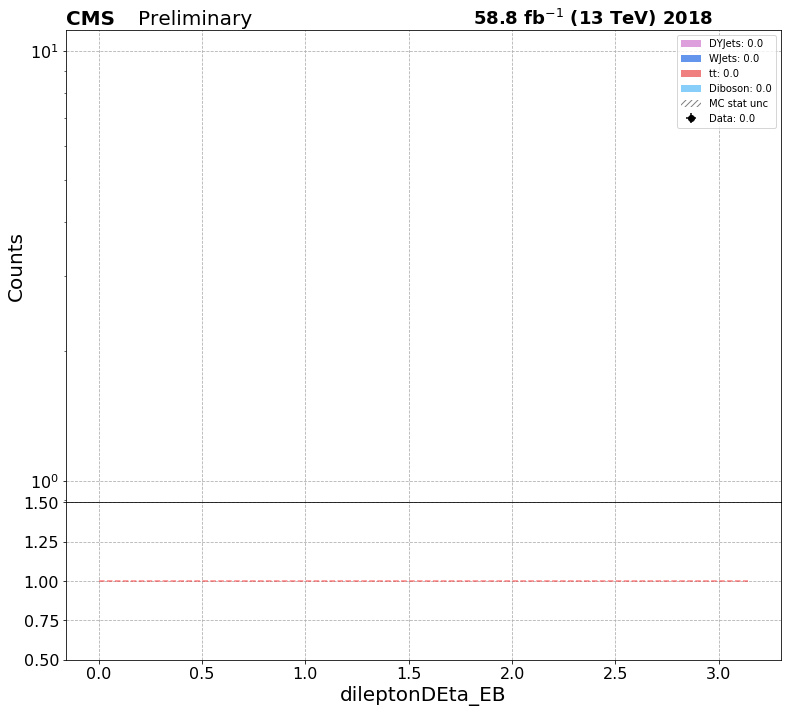

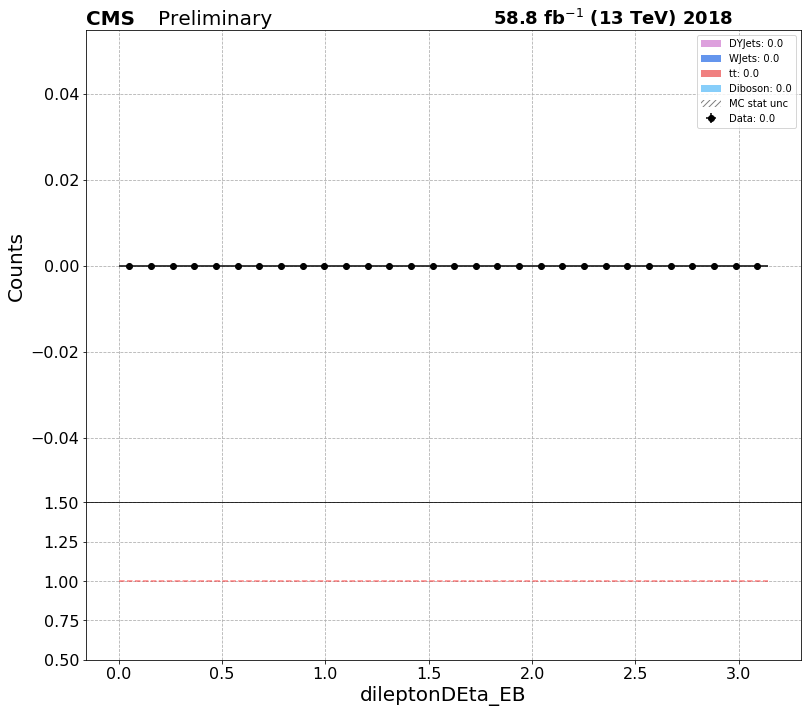

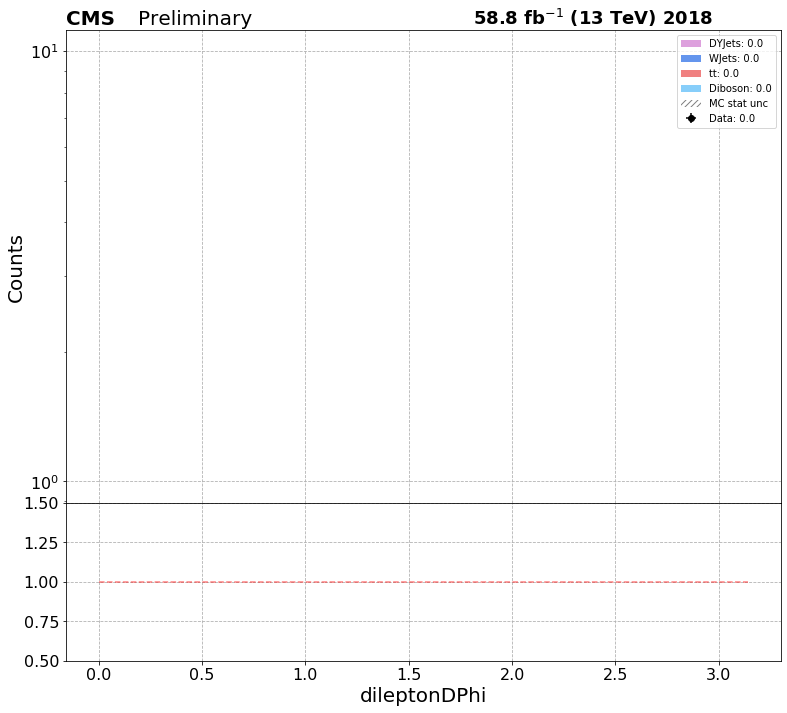

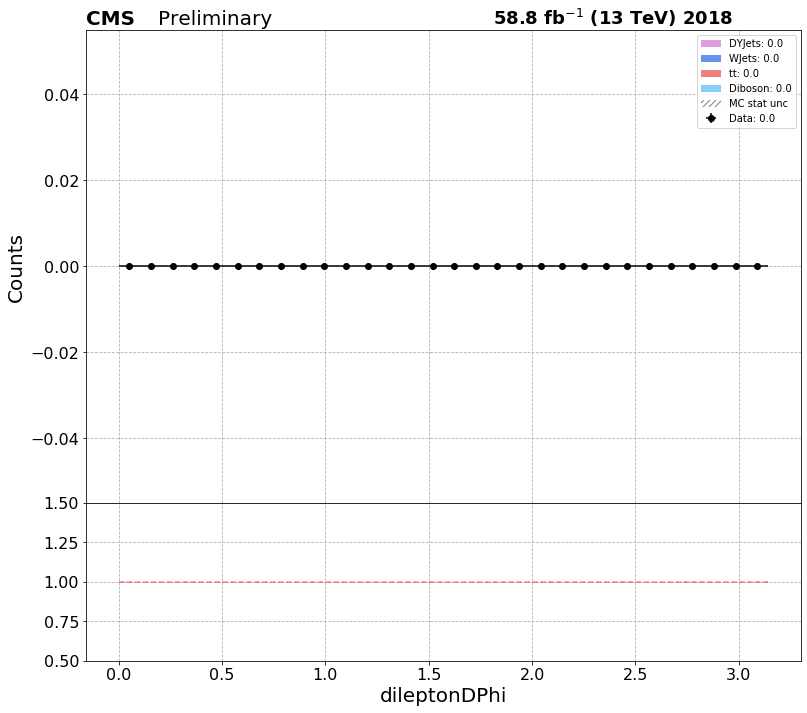

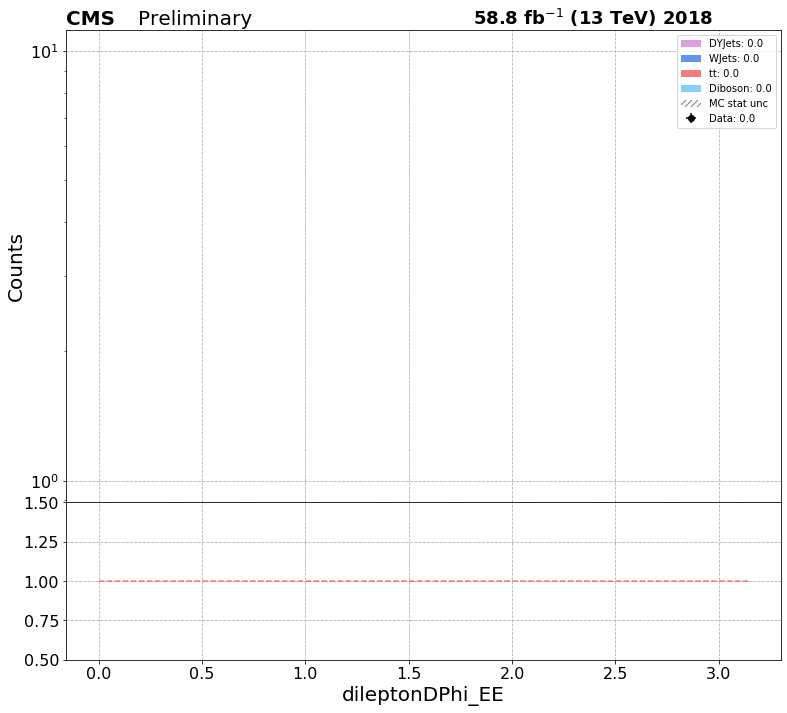

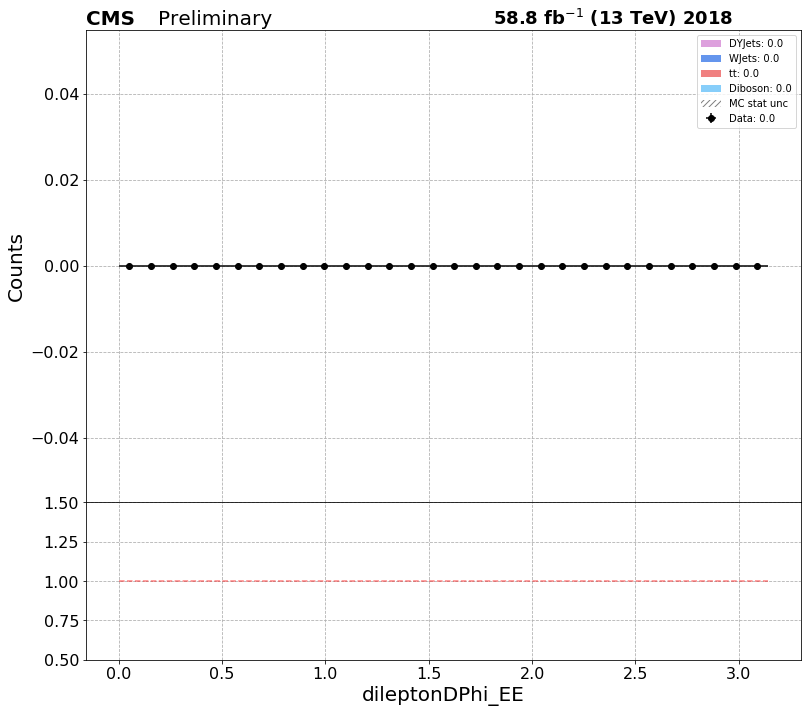

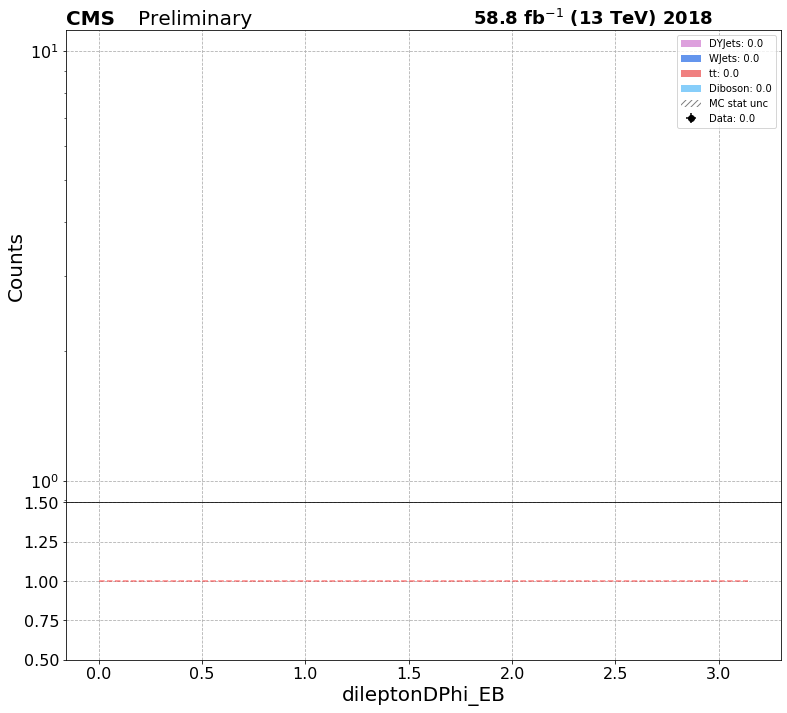

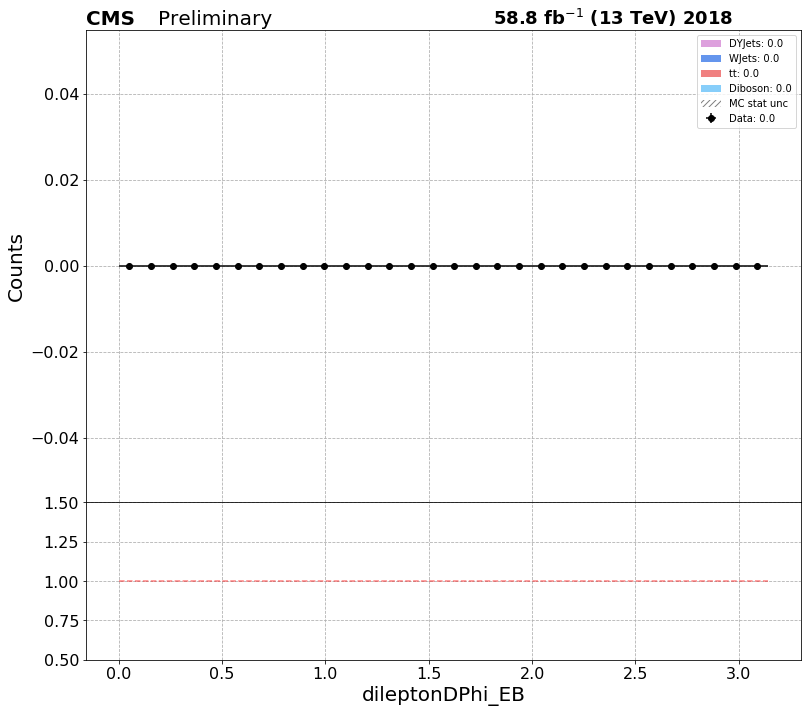

In [16]:
if selection == 'mumug':
    ind  = ['DoubleMuon','WJets', 'TTTo2L2Nu','Diboson' , 'DYJets', 'ZGToLLG']
elif selection == 'mumug':
    ind  = ['DoubleEG','WJets', 'TTTo2L2Nu','Diboson' , 'DYJets', 'ZGToLLG']
elif selection == 'ee':
    ind  = ['Electron','WJets', 'TTTo2L2Nu','Diboson' , 'DYJets', 'ZGToLLG']

dirstructure = os.path.join(HEra.name,selection,Manager.Date())
    
histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
histsavepath += os.path.join(HEra.name,selection,Manager.Date())    
    
figpath = "/home/jcordero/CMS/SMP_ZGamma/fig/"
figpath = os.path.join(figpath,dirstructure)    

#HEra.savefigs(fullpath=figpath,Type="mult", ind=ind,WithYield=True)
for var in HEra[0][0].names:
    for log in [True,False]:
        LOG = "log" if log else "linear"
        #fig = plt.figure()
        fig = HEra.plotmult(variable=var,
                            ind = None,
                            #ind=ind,
                            WithYield=True,log=log)
        fig.savefig(os.path.join(figpath,LOG,"single",var) )
        #HEra.savefig(fig,os.path.join(figpath,log,"single",var) )

In [ ]:
color = [HEra['2018'].getColor(name) for name in HEra['2018'].names]
label = [HEra['2018'].getLabel(name) for name in HEra['2018'].names]
histtype = 'step'

In [ ]:
HEra['2018'].getProperties(HEra['2018'].getMCName())

In [ ]:
#np.array(HEra[era].names)[0]
#np.argsort(HEra[era].sizes())
#HEra[era][[0]]


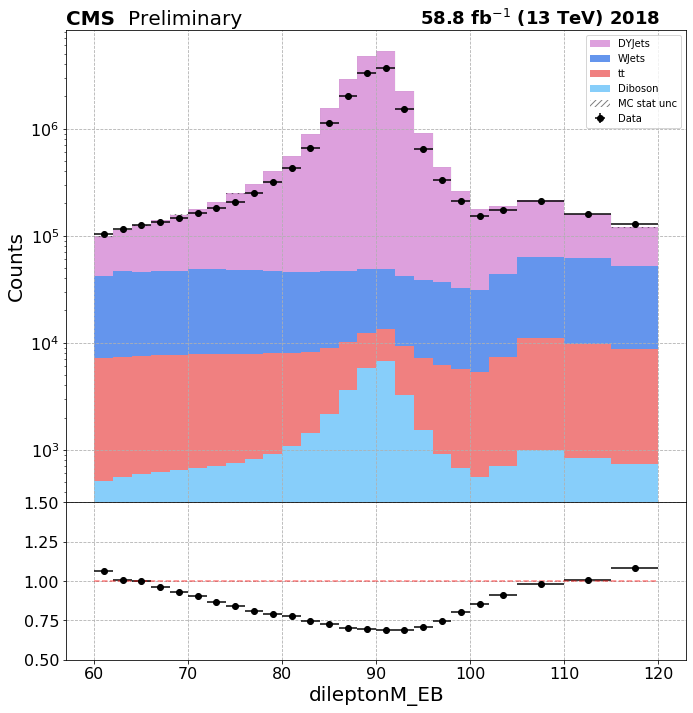

In [15]:
era ='2018'
figpath = "/home/jcordero/CMS/SMP_ZGamma/fig/"
dirstructure = os.path.join(era,selection,Manager.Date())
figpath = os.path.join(figpath,dirstructure)

#variable = 'dileptonM_EE'
variable = 'dileptonM_EB'
#variable = 'dileptonM'
fig, ax = HEra[era].plot( variable=variable,log=True,
                         ind = None,)
                          #ind = ind,)
                          #WithYield = True,)
                          #xranges = [50,200],)
                          #xranges = [60,90],)
                          #yranges=[0,12000],)
                          #limranges = [.8,1.2] )
                          #,Debug=True )
HEra[era].savefig(fig,os.path.join(figpath,variable))

In [ ]:
for era in ['2016','2017','2018']:
    dirstructure = os.path.join(era,selection,Manager.Date())
    
    histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
    histsavepath += os.path.join(era,selection,Manager.Date())    
    
    figpath = "/home/jcordero/CMS/SMP_ZGamma/fig/"
    figpath = os.path.join(figpath,dirstructure)
    
    try:
        HEra[era].savefig(fig,os.path.join(figpath,variable))
    except:
        print("Could not save fig in era {}".format(era))
    
        
    try:        
        HEra[era].savehists(path = histsavepath)
    except:
        print("Could not save histo in era {}".format(era))
    


In [ ]:
figpath

In [ ]:
for era in ['2016','2017','2018']:
    dirstructure = os.path.join(era,selection,Manager.Date())
    
    histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
    histsavepath += os.path.join(era,selection,Manager.Date())    
    
    figpath = "/home/jcordero/CMS/SMP_ZGamma/fig/"
    figpath = os.path.join(figpath,dirstructure)    
    try:
        HEra[era].savefigs(figpath, ind=ind)
    except:
        print("Could not save fig in era {}".format(era))

In [ ]:
Runs = ['2016','2017','2018']
plt.figure(figsize=(12*len(Runs),10))
variable = 'dileptonM_EB'
for i, era in enumerate(Runs):
    fig, ax = HEra[era].plot( variable=variable,log=True,
                              ind = ind,
                              #ind = ['TTTo2L2Nu'],
                              shape=(4,len(Runs)),loc = i,
                              WithYield = True,
                              Create = False,
                            )
                              #xranges = [50,200],)
                              #xranges = [60,90],)
                              #yranges=[0,12000],)
                              #limranges = [.8,1.2] )
                              #,Debug=True )

In [ ]:
variable = 'dileptonM'
plt.figure()
fig, ax = HEra['2018'].plot( variable=variable,log=True,
                          ind = ind,                          
                          shape=(4,1),loc = 0,
                          WithYield = True,
                          Create = False,
                        )
                          #xranges = [50,200],)
                          #xranges = [60,90],)
                          #yranges=[0,12000],)
                          #limranges = [.8,1.2] )
                          #,Debug=True )

In [ ]:

dirstructure = os.path.join(HEra.name,selection,Manager.Date())
    
histsavepath = "/home/jcordero/CMS/SMP_ZGamma/histo/"
histsavepath += os.path.join(HEra.name,selection,Manager.Date())    
    
figpath = "/home/jcordero/CMS/SMP_ZGamma/fig/"
figpath = os.path.join(figpath,dirstructure)    

HEra.savefigs(fullpath=figpath,Type="mult", ind=ind,WithYield=True)
